In [2]:
%matplotlib inline
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

torch.Size([595, 4, 4096])

In [ ]:
def get_activations(output_dir, cat, layer):

    activations_path = f"{output_dir}/{cat}/activations"
    files = [f"{i}_activations.pt" for i in range(len(os.listdir(activations_path)))]

    activations = torch.cat([torch.load(f"{activations_path}/{f}", weights_only=True) for f in files], dim=0)

    return activations[:, layer]

def get_df(activations, cat, col):

    df = pd.read_csv(f"{output_dir}/{cat}/{cat}.csv")

    return df[col]

cat =  "science_elementary"
output_dir = Path(f".output")

In [42]:
from sklearn.decomposition import PCA

def plot_pca(activations, label, title):

    pca = PCA(n_components=2)

    activations_pca = pca.fit_transform(activations)

    # plot pca
    plt.figure(figsize=(10, 10))
    plt.title(title)
    sns.scatterplot(x=activations_pca[:, 0], y=activations_pca[:, 1], hue=label, palette="tab10")
    plt.show()

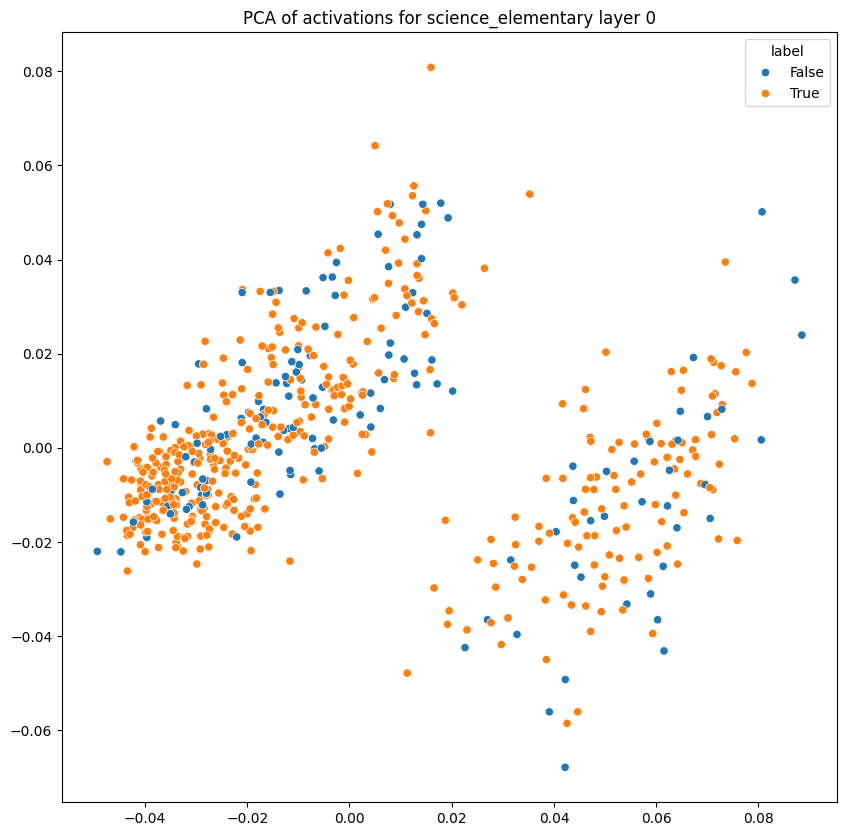

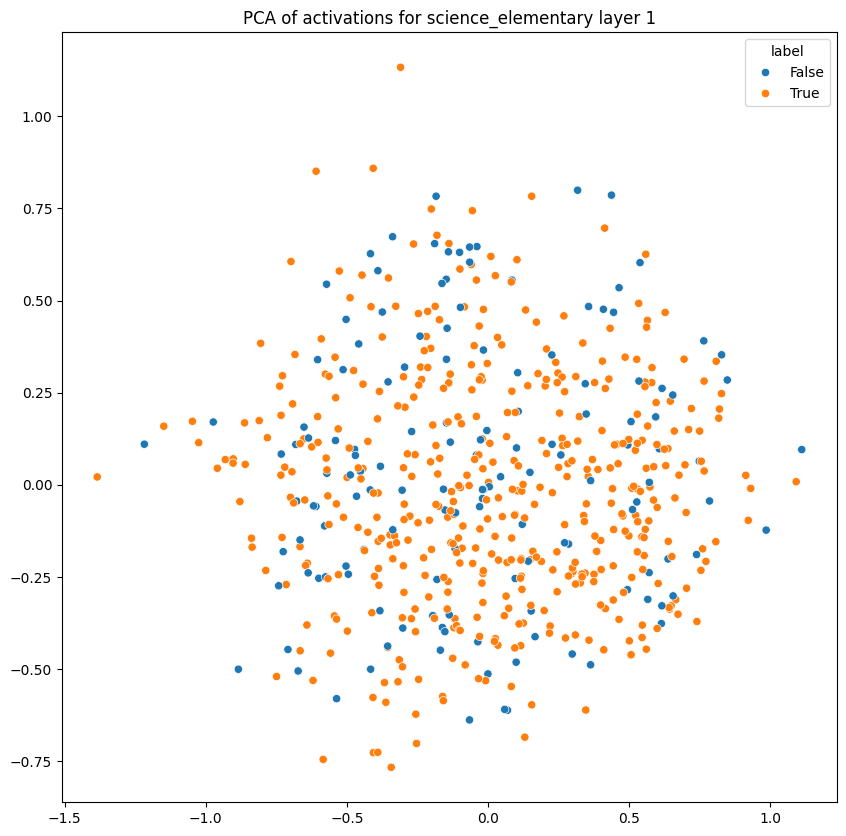

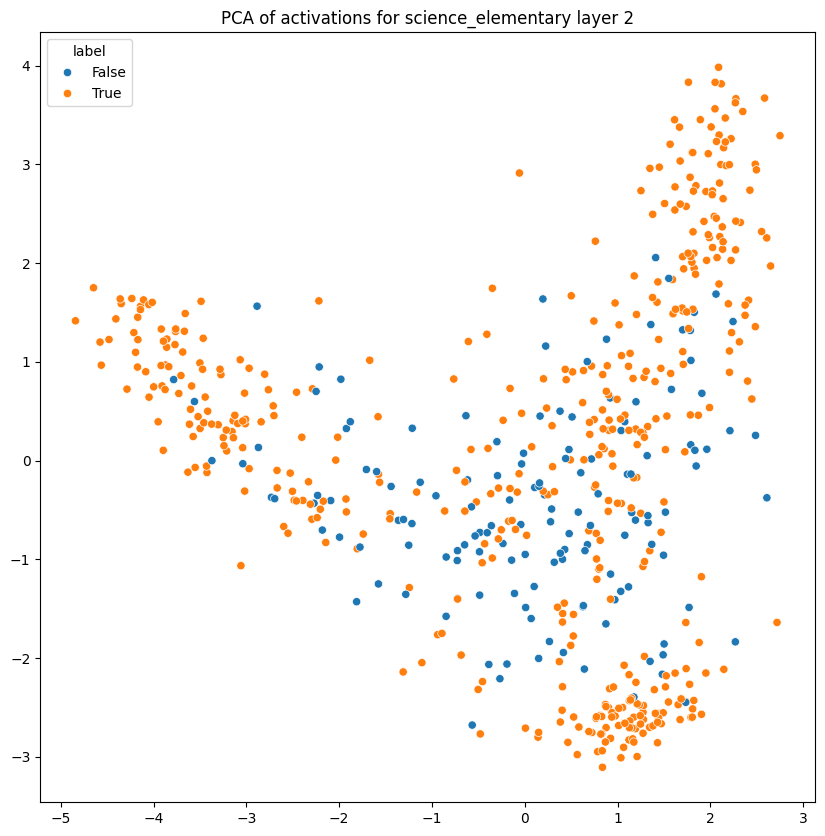

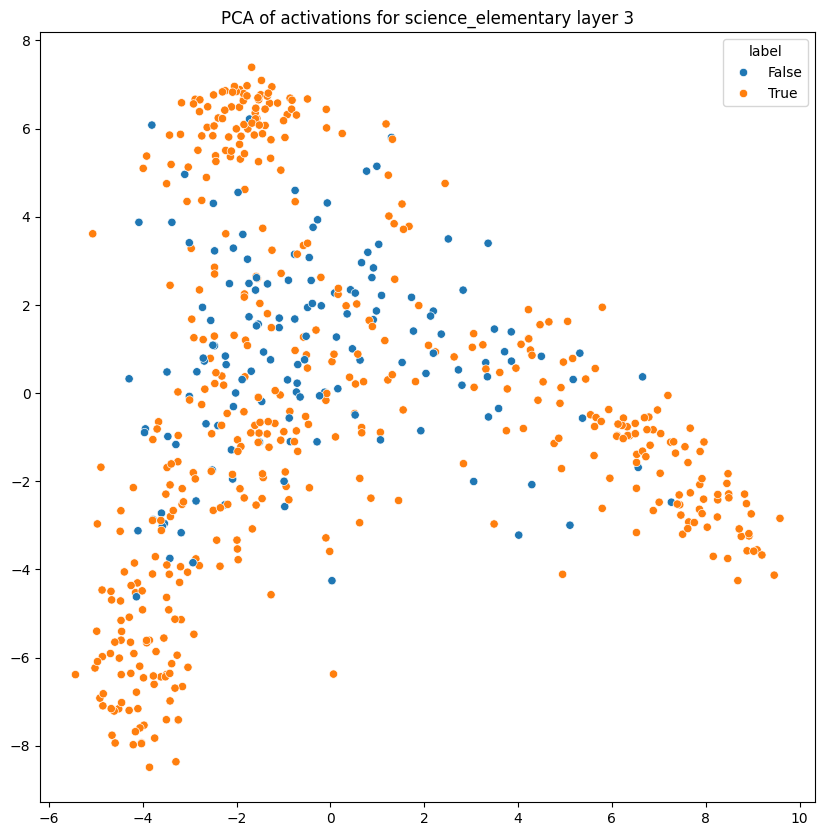

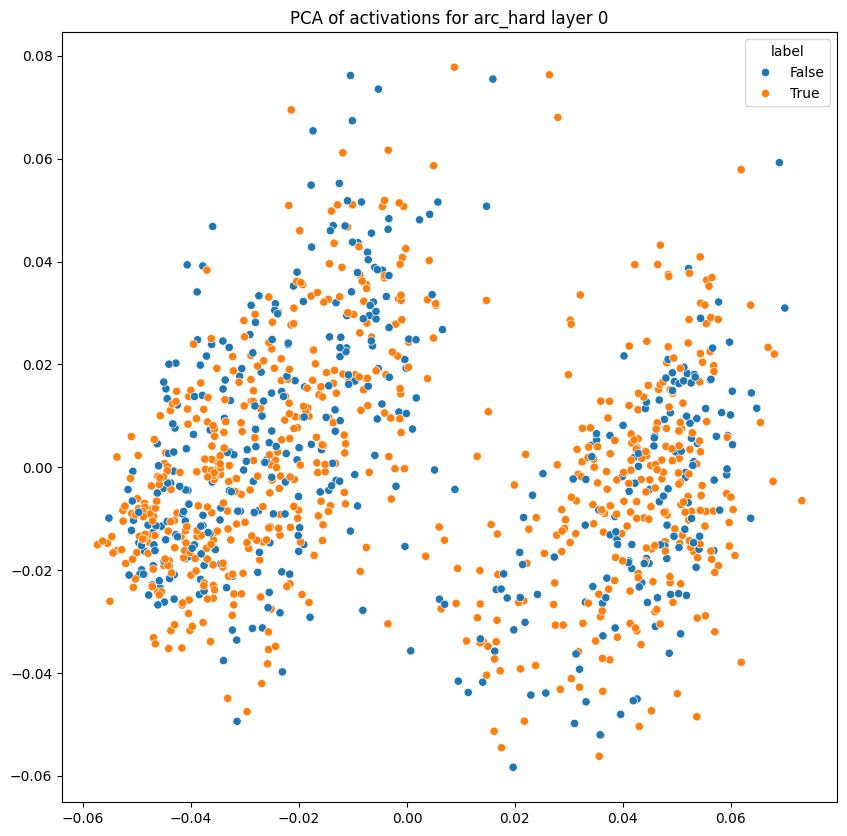

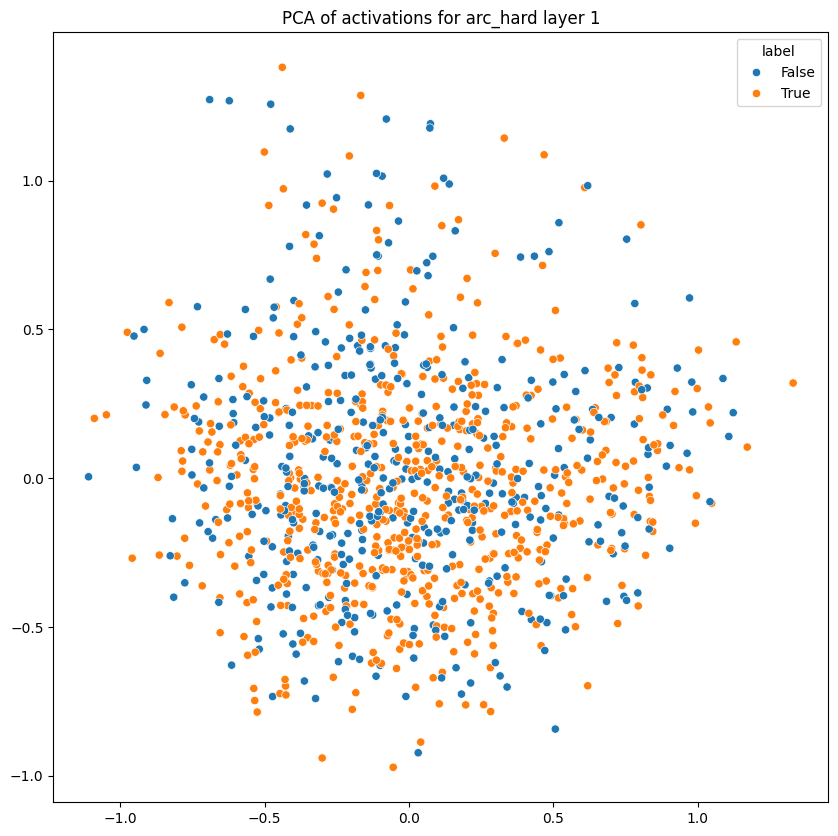

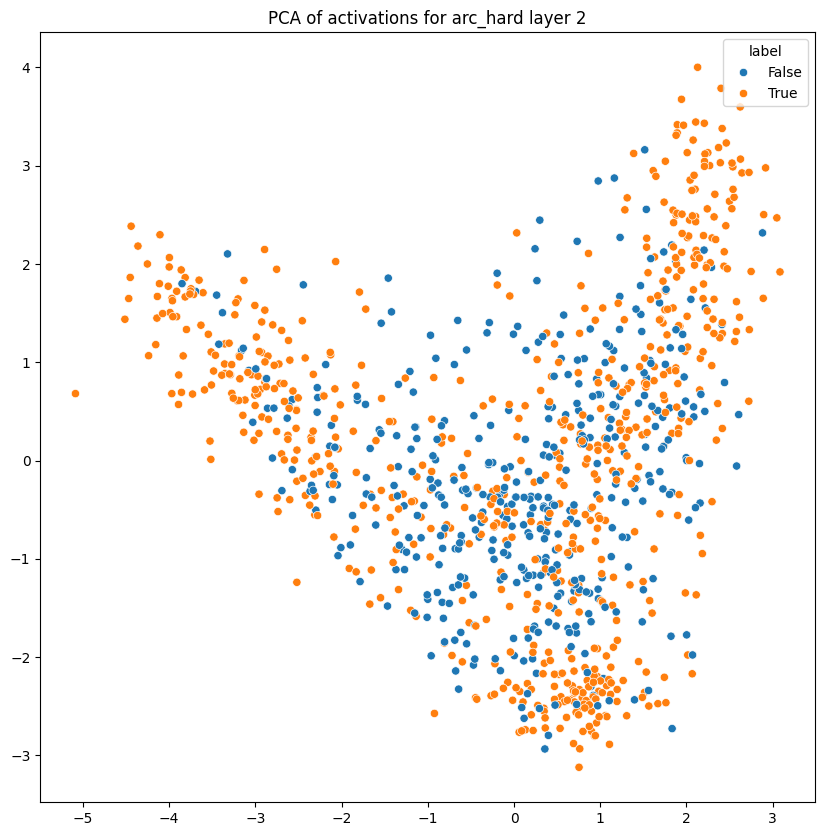

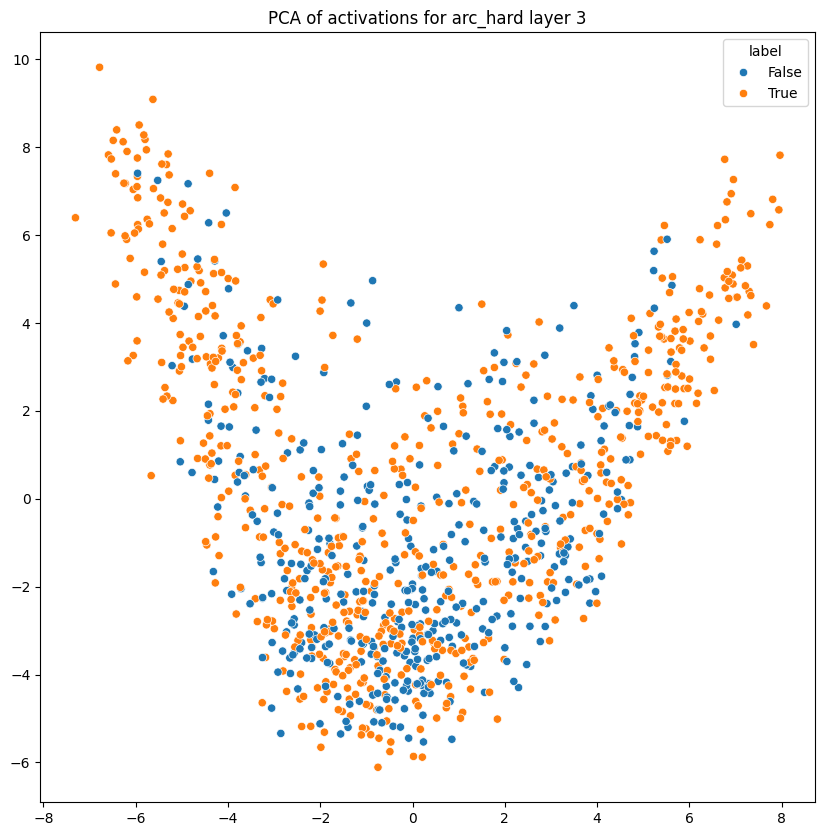

In [43]:
for cat in ["science_elementary", "arc_hard"]:
    for layer in range(4):
        activations = get_activations(output_dir, cat, layer).float().cpu().numpy()
        label = get_df(activations, cat, "label")

        title = f"PCA of activations for {cat} layer {layer}"
        plot_pca(activations, label, title)

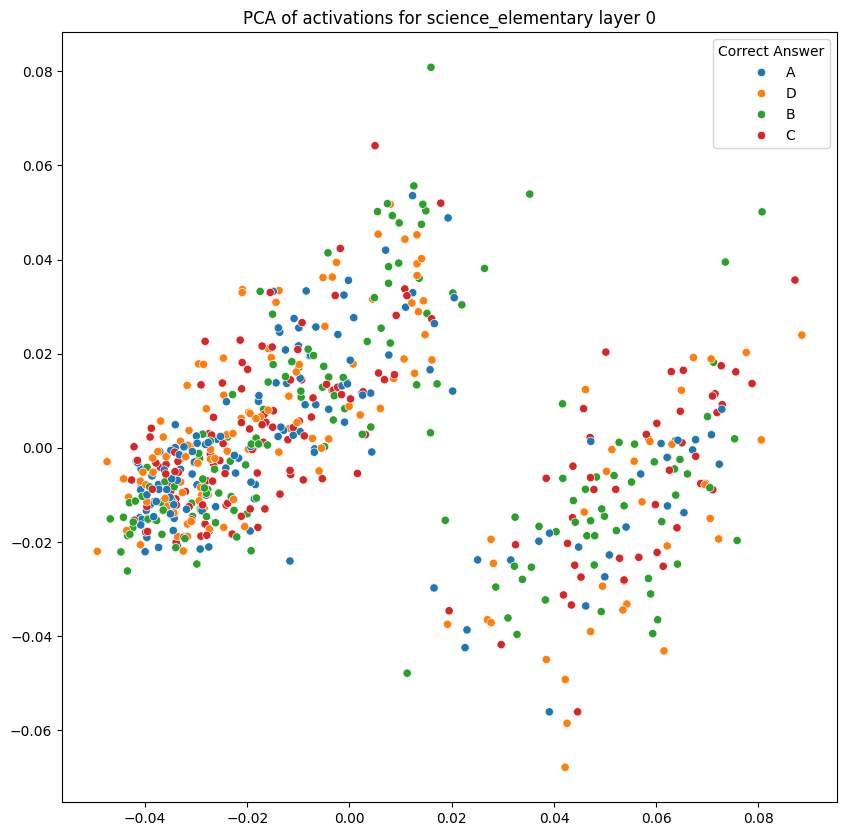

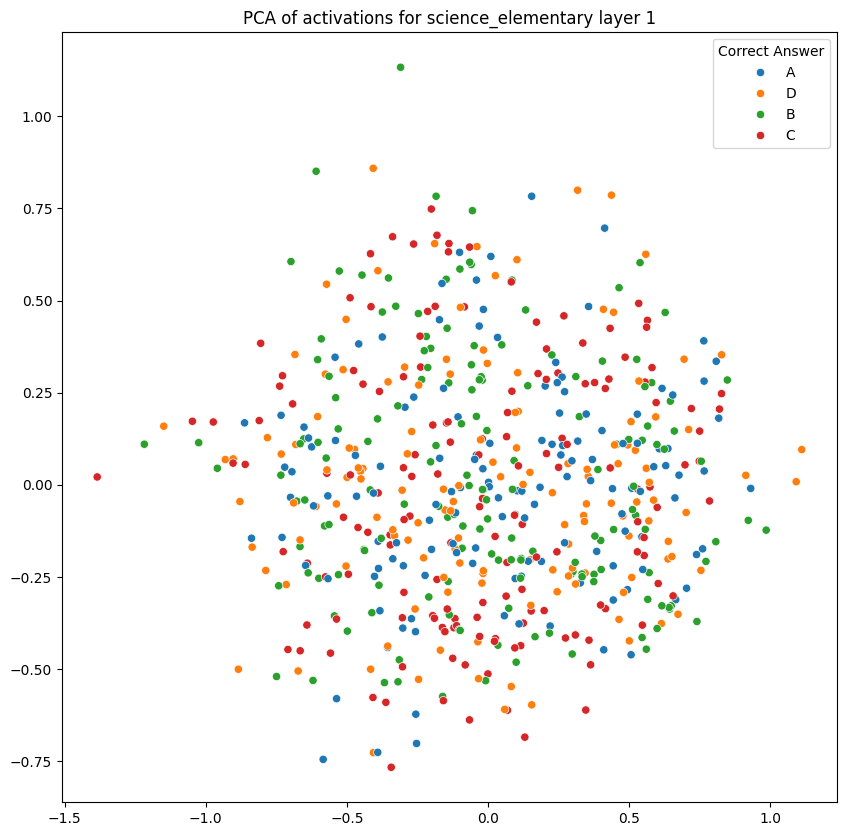

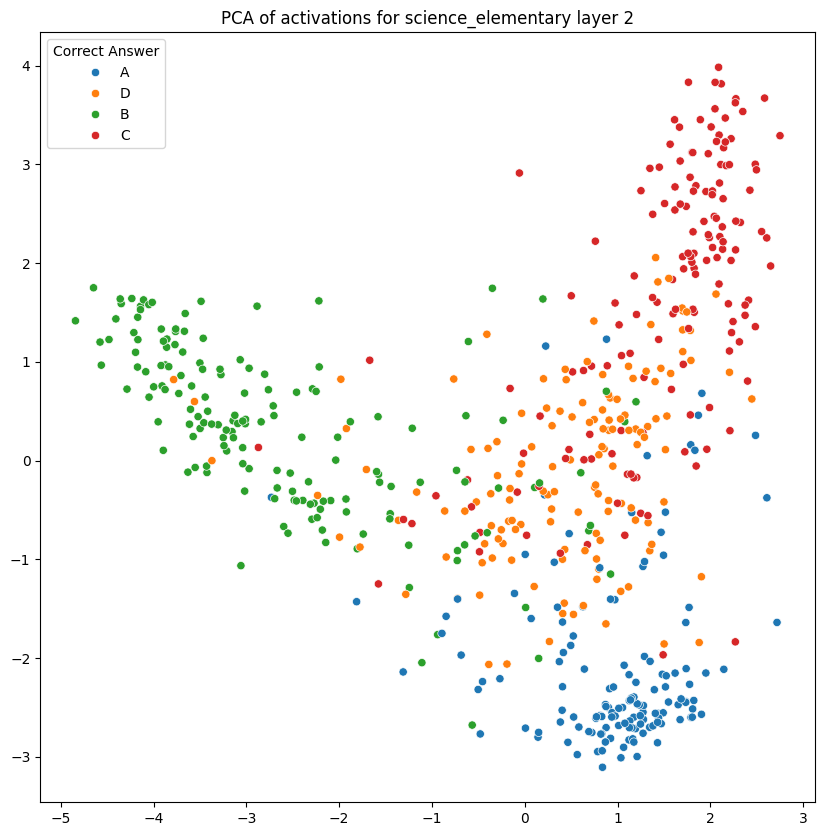

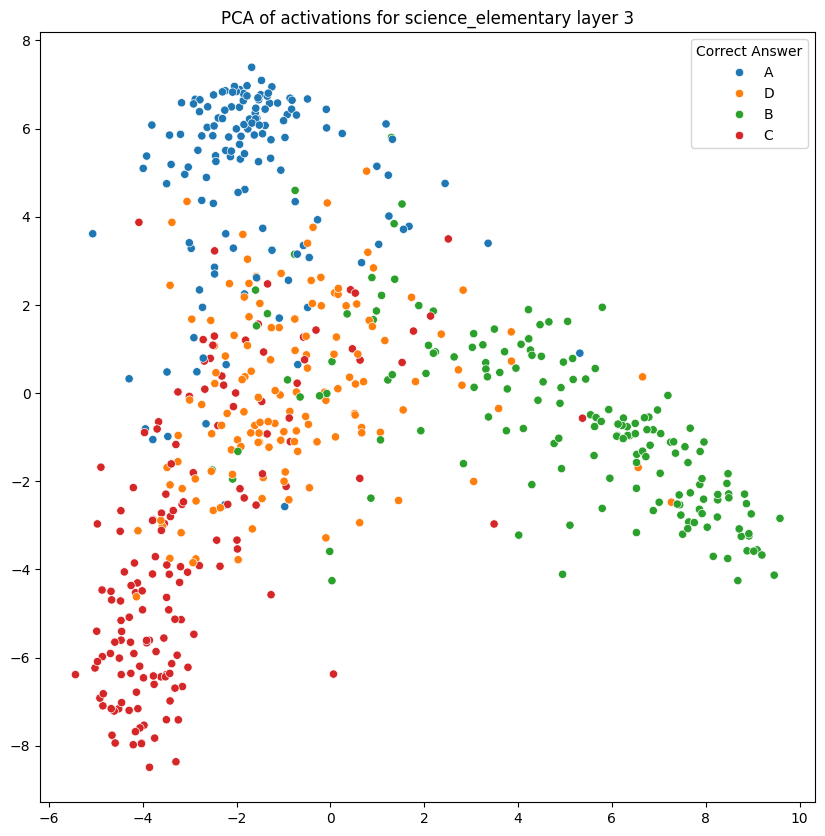

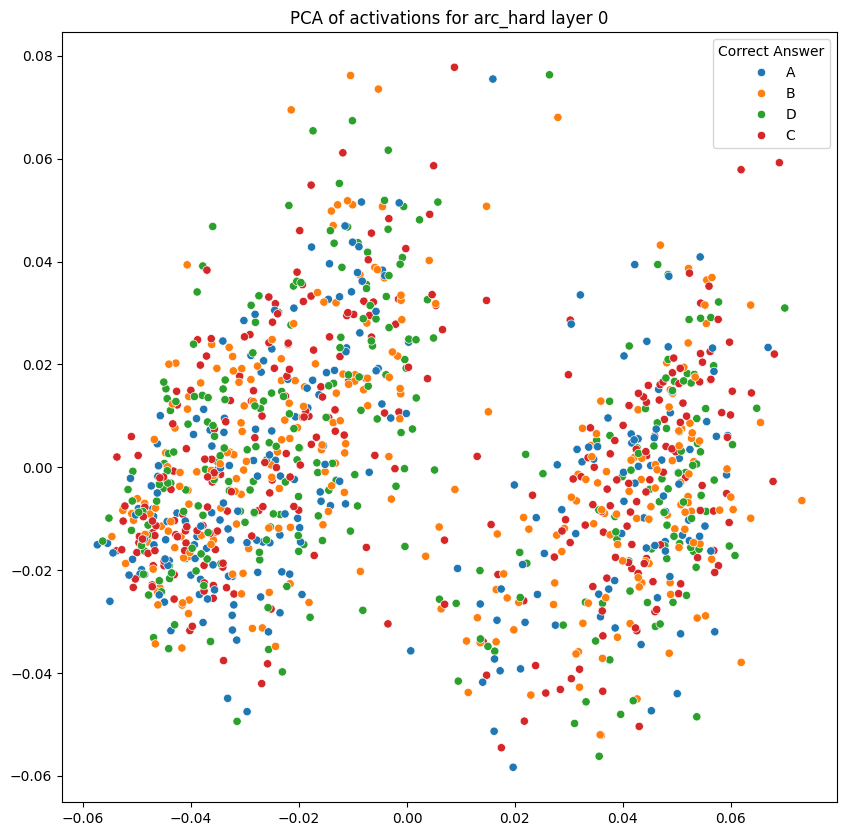

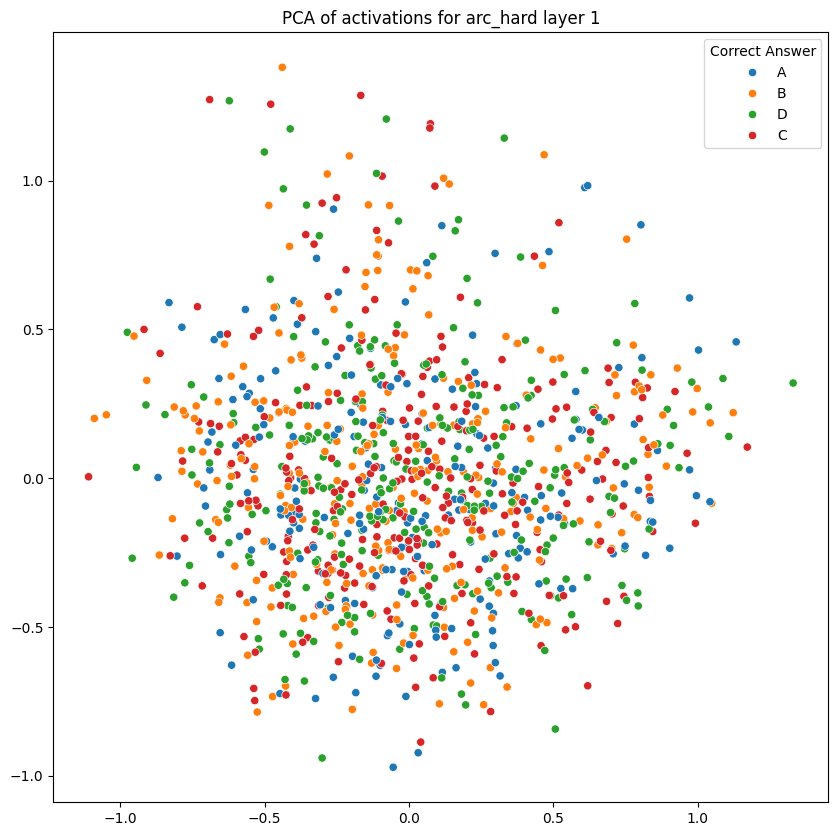

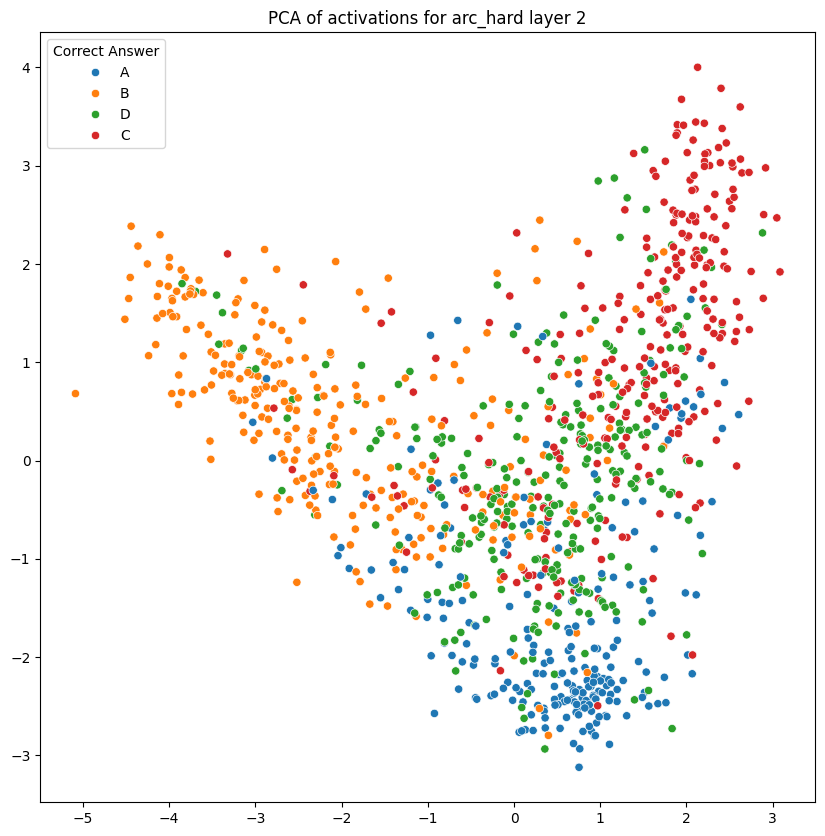

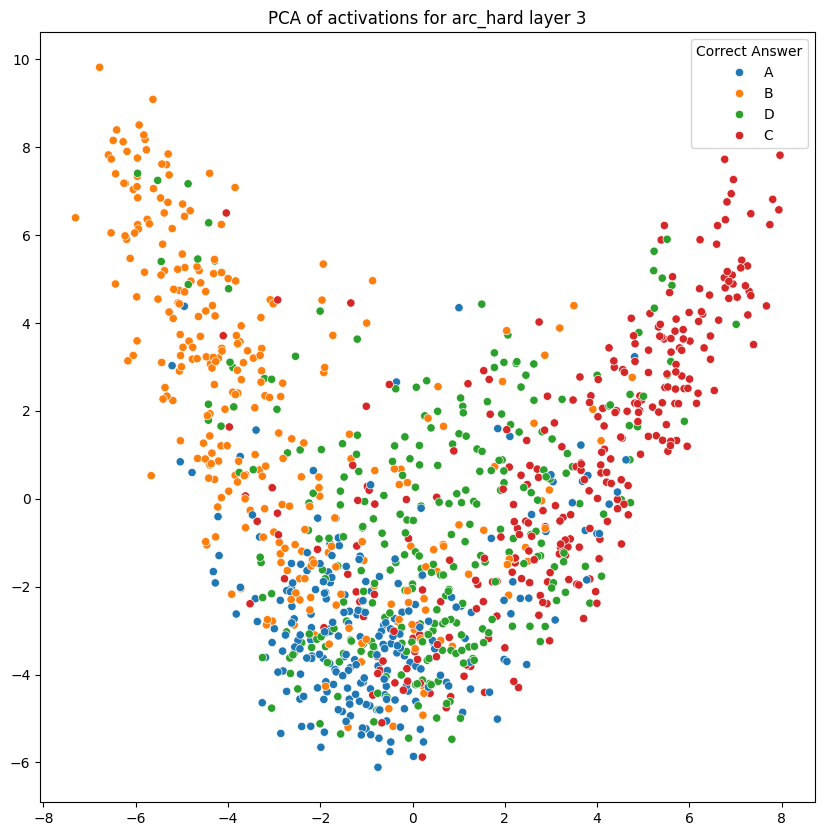

In [44]:
for cat in ["science_elementary", "arc_hard"]:
    for layer in range(4):
        activations = get_activations(output_dir, cat, layer).float().cpu().numpy()
        label = get_df(activations, cat, 'Correct Answer')

        title = f"PCA of activations for {cat} layer {layer}"
        plot_pca(activations, label, title)

In [48]:
layers = torch.Tensor([1, 1, 1, 1]).to(torch.bool)
total_activations = torch.cat([get_activations(output_dir, cat, layers) for cat in ["science_elementary", "arc_hard"]], dim=0).float().cpu().numpy()


In [49]:
total_activations.shape

(1677, 4, 4096)

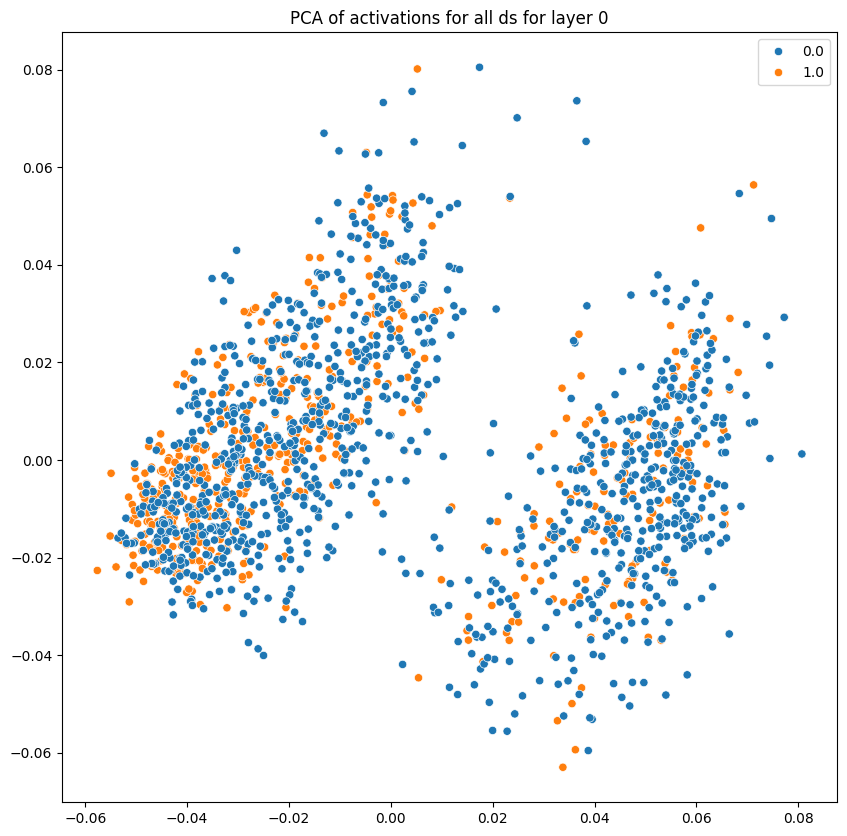

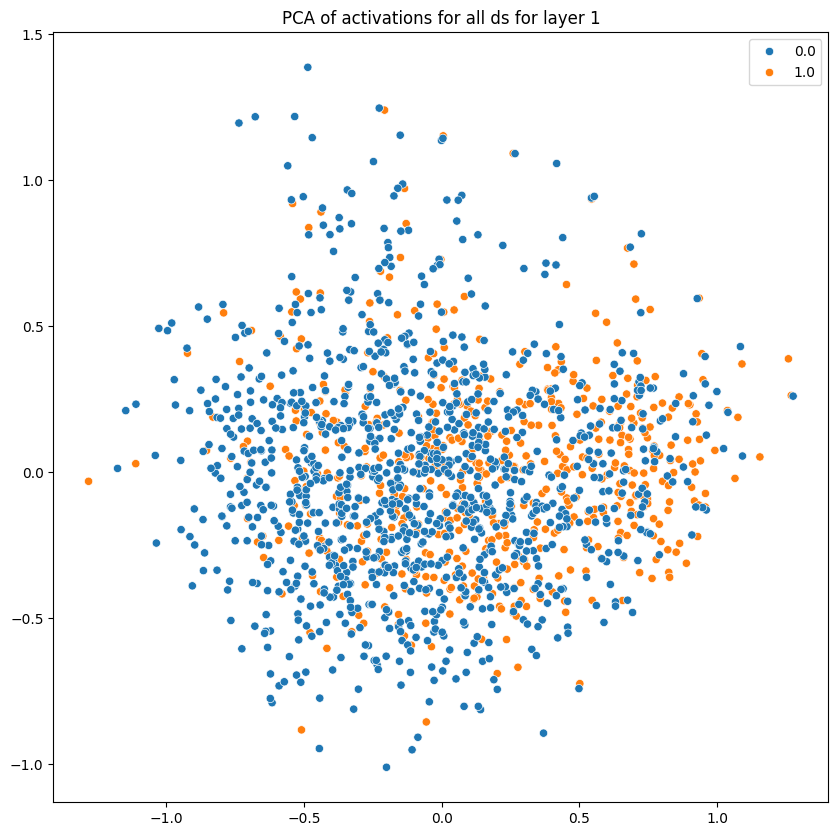

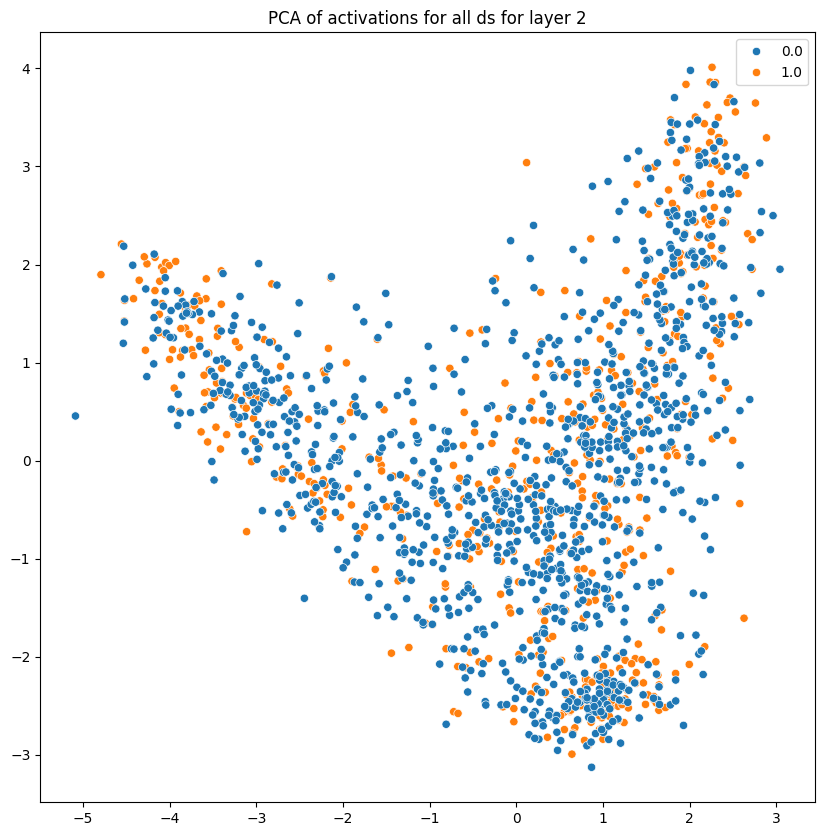

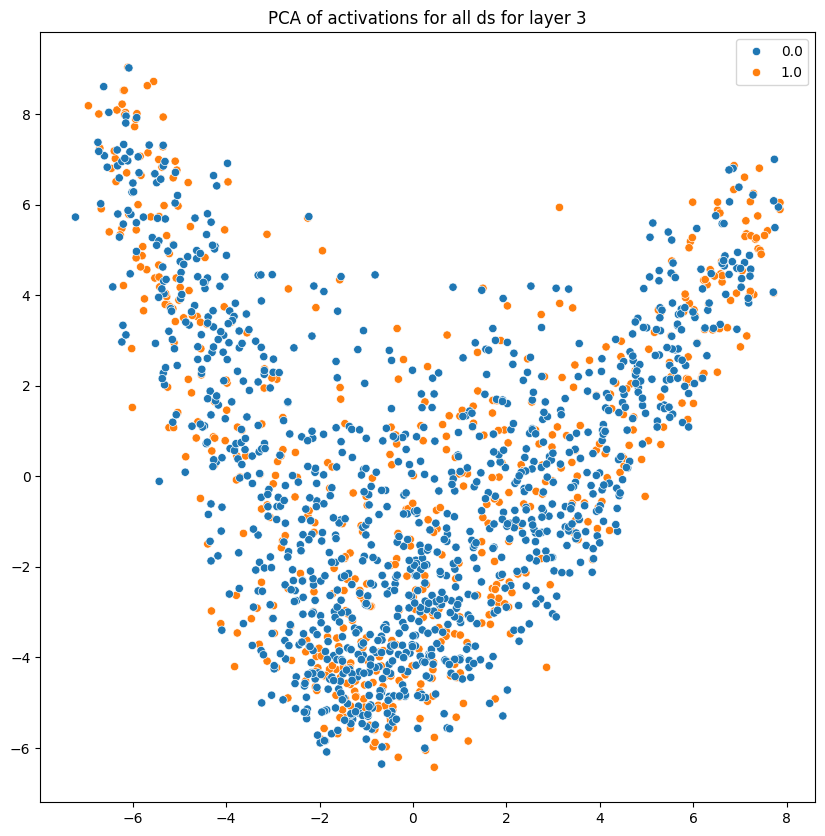

In [52]:
for layer in range(4):
    act1, act2 = get_activations(output_dir, "science_elementary", layer), get_activations(output_dir, "arc_hard", layer)
    full_activations = torch.cat([act1, act2], dim=0).float().cpu().numpy()

    label = torch.cat([torch.ones(act1.shape[0]), torch.zeros(act2.shape[0])]).numpy()

    title = f"PCA of activations for all ds for layer {layer}"
    plot_pca(full_activations, label, title)

In [ ]:
cat =  "arc_hard"
output_dir = Path(f".output")

activations_path = f"{output_dir}/{cat}/activations"
files = [f"{i}_activations.pt" for i in range(len(os.listdir(activations_path)))]

activations2 = torch.cat([torch.load(f"{activations_path}/{f}", weights_only=True) for f in files], dim=0)

activations2.shape

torch.Size([1082, 4, 4096])

In [ ]:
cat =  "arc_hard"
output_dir = Path(f".output")

activations_path = f"{output_dir}/{cat}/activations"
files = [f"{i}_activations.pt" for i in range(len(os.listdir(activations_path)))]

activations2 = torch.cat([torch.load(f"{activations_path}/{f}", weights_only=True) for f in files], dim=0)

activations2.shape

torch.Size([1082, 4, 4096])

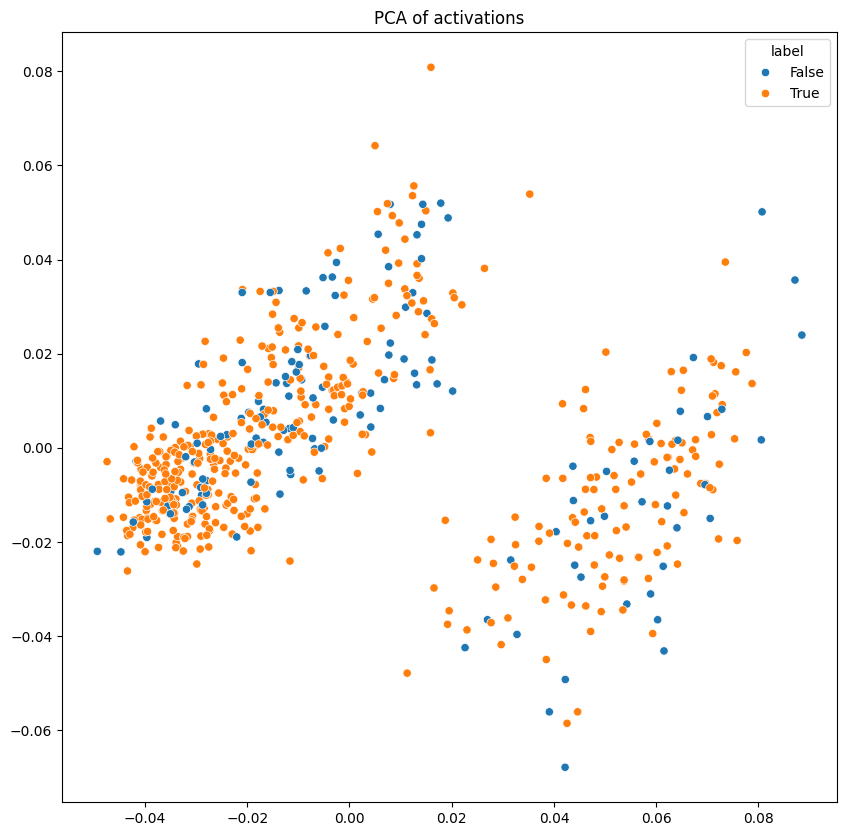

In [ ]:
activations0 = activations[:, 0].float().cpu().numpy()
# apply pca to activations



In [27]:
cat =  "arc_hard"
output_dir = Path(f".output")

activations_path = f"{output_dir}/{cat}/activations"
files = [f"{i}_activations.pt" for i in range(len(os.listdir(activations_path)))]

activations2 = torch.cat([torch.load(f"{activations_path}/{f}", weights_only=True) for f in files], dim=0)

activations2.shape

torch.Size([1082, 4, 4096])

In [32]:
df = pd.read_csv(f"{output_dir}/{cat}/{cat}.csv")
label = df["label"]
label2 = df["Predicted Answer"]
label2.value_counts()

Predicted Answer
B    325
C    301
A    253
D    203
Name: count, dtype: int64

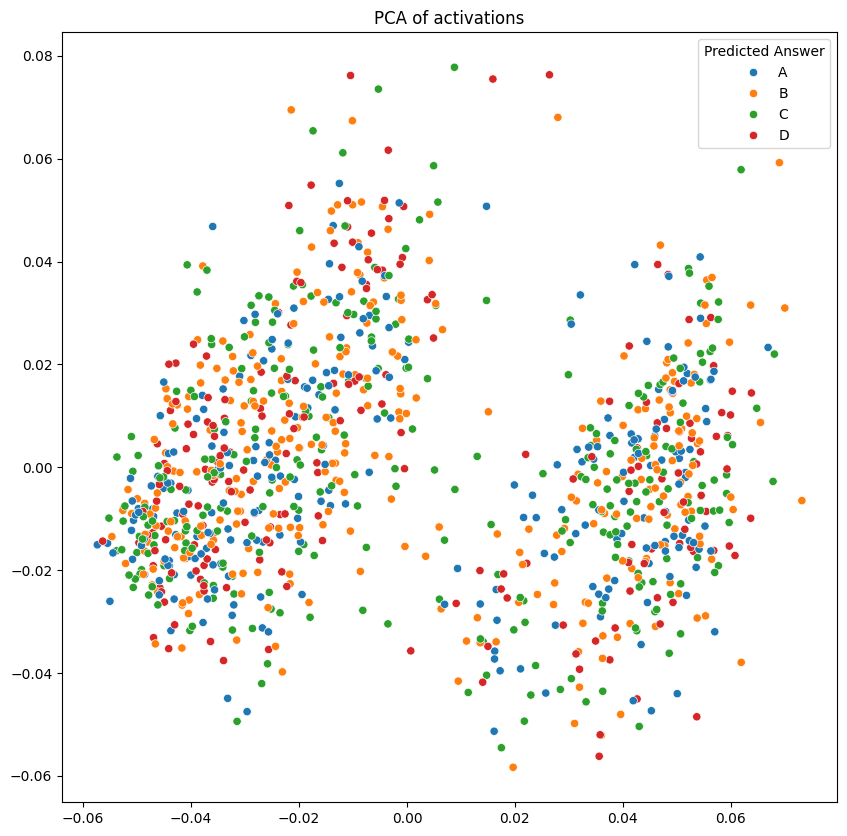

In [33]:
activations20 = activations2[:, 0].float().cpu().numpy()
# apply pca to activations
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

activations2_pca = pca.fit_transform(activations20)

# plot pca
plt.figure(figsize=(10, 10))
sns.scatterplot(x=activations2_pca[:, 0], y=activations2_pca[:, 1], hue=label2, palette="tab10")
plt.title("PCA of activations")
plt.show()


In [9]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
class BatchFileDataset(Dataset):
    def __init__(self, output_path, cat, layer, task):
        """
        Args:
            x_folder (str): Path to the folder containing x batch files (e.g., 'batch_0.pt', 'batch_1.pt', etc.).
            y_column (pd.Series): Continuous pandas Series with labels.
            batch_size (int): The size of each batch.
        """
        self.output_path = output_path
        self.x_files_path = f"{output_path}/{cat}/activations"
        self.y_file_path = f"{output_path}/{cat}/{cat}.csv"
        self.batch_size = 32

        num_x_files = len([f for f in os.listdir(self.x_files_path) if f.endswith('.pt')])
        self.x_files = [f"{i}_activations.pt" for i in range(num_x_files)]

        self.layer = layer
        self.task = task
        self.y_batches = self.setup_y_batches()

    def setup_y_batches(self):
        df = pd.read_csv(self.y_file_path)
        if self.task == "layer":
            return None
        
        y_column = df.label

        y = torch.tensor(y_column).float()
        #print(y, len(y))
        batches = []
        for idx in range(len(self.x_files)):
            batch = y[idx * self.batch_size:(idx + 1) * self.batch_size]
            batches.append(batch)
        return batches

    def __len__(self):
        # Number of batch files determines the length
        if self.task == "layer":
            print("approximating length")
            return len(self.x_files) * 32
            
        return len(self.x_files)

    def __getitem__(self, idx):
        # Load the x batch file
        x_path = os.path.join(self.x_files_path, self.x_files[idx])
        
        if self.task == "correctness":
            y = self.y_batches[idx]
            x = torch.load(x_path, weights_only=True)[:, self.layer]
        elif self.task == "layer":
            x = torch.load(x_path, weights_only=True)
            x = x[np.random.randint(0, x.shape[0])]
            y = torch.tensor([0., 1., 2., 3.], device='cuda:0', dtype=torch.long)

            y_one_hot = torch.nn.functional.one_hot(y, num_classes=4).to(torch.float32)
            # shuffle x, y
            idx = torch.randperm(x.shape[0])
            x = x[idx]
            y = y[idx]

        if y.shape[0] != x.shape[0]:
            print(idx, y.shape, x.shape)
        
        return x, y
    
def collate_fn(batch):
    batch = batch[0]
    return batch
    
def get_loader(output_path, cat, layer, task):
    ds = BatchFileDataset(output_path, cat, layer, task)
    return DataLoader(dataset=ds, batch_size=1, collate_fn=collate_fn)
    

    

In [91]:
# cat = "abstract_algebra"
# df = pd.read_csv(f"{output_dir}/{cat}/{cat}.csv")
# df["label"] = df['Correct Answer'] == df['Predicted Answer']
# df.drop(columns=["Unnamed: 0"], inplace=True)
# df.to_csv(f"{output_dir}/{cat}/{cat}.csv", index=False)

In [92]:
cat =  "science_elementary"
output_dir = Path(f".output")
data_loader = get_loader(output_path=".output/", cat="abstract_algebra", layer=3, task="correctness")


In [93]:
def split_datasets(data_loader, task):
    if task == "correctness":
        num_batches = len(data_loader.dataset)
        num_train = int(num_batches * 0.8)
        num_val = int(num_batches * 0.1)
        num_test = num_batches - num_train - num_val
        return torch.utils.data.random_split(data_loader.dataset, [num_train, num_val, num_test])

    elif task == "layer":
        num_batches = len(data_loader.dataset)
        num_train = int(num_batches * 0.8)
        num_val = int(num_batches * 0.1)
        num_test = num_batches - num_train - num_val
        return torch.utils.data.random_split(data_loader.dataset, [num_train, num_val, num_test])


In [113]:

def train_model(cat, layer, task):
    output_dir = Path(f".output")
    dataset = BatchFileDataset(output_path=output_dir, cat=cat, layer=layer, task=task)
    data_loader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)
    train_loader, val_loader, test_loader = split_datasets(data_loader, task=task)

    model = SimpleNN(input_size=4096, hidden_size=8)
    trainer = pl.Trainer(max_epochs=5) 
    trainer.fit(model, train_loader, val_loader)
    return trainer, model, test_loader
    # trainer.test(model, test_loader)

    # if not os.path.exists(f"{output_dir}/{cat}/correctness.csv"):
    #     columns = ["layer", "task", "train_loss", "val_loss", "test_loss"]
    #     df = pd.DataFrame(columns=columns)

        
trainer, model, test_loader = train_model(cat="science_elementary", layer=0, task="correctness")
trainer.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\mb4988\AppData\Local\anaconda3\envs\llama-env\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params | Mode 
---------------------------------------------------------
0 | fc1           | Linear         | 32.8 K | train
1 | fc2           | Linear         | 9      | train
2 | sigmoid       | Sigmoid        | 0      | train
3 | test_accuracy | BinaryAccuracy | 0      | train
---------------------------------------------------------
32.8 K    Trainable params
0         Non-trainable params
32.8 K    Total params
0.131     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
c:\Users\mb4988\AppData\Local\anaconda3\envs\llama-env\lib\

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
        1., 1., 1., 0., 1

[{'test_accuracy': 1.0}]

In [111]:
def test_model(model, test_loader, task):
    output = 1 if task == "correctness" else 4
    for x, y in test_loader:
        x = x.view(-1, 4096).float()
        y = y.view(-1, output).float()
        outputs = model(x)
        print("Test accuracy: ", torch.sum((outputs > 0.5) == y.byte()).item() / len(y))

In [212]:
import pandas as pd
mmlu_dir = Path.home() / "Downloads\\mmlu_data_clean\\auxiliary_train\\"
output_path = ".output/"

factoid_cat = os.path.join(mmlu_dir, "science_elementary.csv")
reasoning_cat = os.path.join(mmlu_dir, "arc_hard.csv")

factoid_output = os.path.join(output_path, "science_elementary_og", "factoid_results.csv")

df = pd.read_csv(factoid_output)
df.columns


Index(['Unnamed: 0', 'Predicted Answer', 'Full Answer', 'Prompts',
       'Correct Answer', 'Label'],
      dtype='object')

In [14]:
len(df)

595

In [15]:
df["label"] = df["Correct Answer"] == df["Predicted Answer"]
df.label.mean()

0.7596638655462185

In [16]:
cat = "science_elementary_og"
data_loader = DataLoader(BatchFileDataset(f"{output_dir}/{cat}/activations", df["label"], 32), batch_size=1, shuffle=False)


In [45]:
x, y = next(iter(data_loader))
x.shape, y.shape

torch.Size([32, 4096]) torch.Size([1])


C:\Users\mb4988\AppData\Local\Temp\ipykernel_20208\2168430911.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load(x_path)[:, self.layer]


(torch.Size([32, 4096]), torch.Size([1]))

In [46]:
df.shape[0]

595

<Axes: >

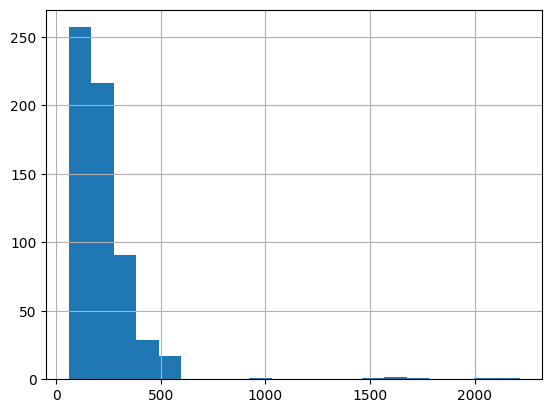

In [23]:
df["Prompt length"].hist(bins=20)

In [22]:
[max(df.iloc[i * 32: (i + 1) * 32]["Prompt length"]) for i in range(10)]

[516, 479, 311, 593, 2214, 483, 421, 365, 374, 274]

<Axes: >

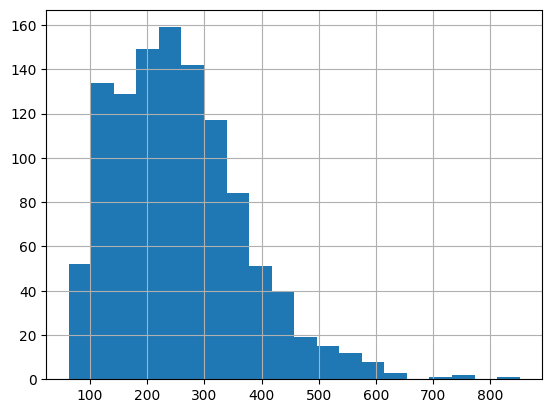

In [24]:
df2 = pd.read_csv(reasoning_cat)
df2["Prompt length"] = df2["Prompt"].apply(len)
df2["Prompt length"].hist(bins=20)

In [3]:
len(attentions)

32

In [7]:
attentions[0].shape # (batch_size, num_heads, seq_len, seq_len)

torch.Size([32, 32, 134, 134])

In [5]:
len(attention_maps[0])

32

In [6]:
attention_maps[0][0].shape

torch.Size([1, 32, 57, 57])

In [7]:
attention_maps[0][0][0][0].shape

torch.Size([57, 57])

In [8]:
attention_maps[0][0][0][0].cpu().to(torch.float32).detach().numpy()

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [6.9921875e-01, 3.0273438e-01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [5.3515625e-01, 4.1601562e-01, 5.0048828e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.2145996e-02, 9.7751617e-05, 2.0694733e-04, ..., 2.1679688e-01,
        0.0000000e+00, 0.0000000e+00],
       [7.8613281e-02, 1.0375977e-03, 8.8882446e-04, ..., 4.1210938e-01,
        9.0820312e-02, 0.0000000e+00],
       [5.3710938e-03, 2.0623207e-05, 4.4405460e-06, ..., 7.5781250e-01,
        6.1035156e-02, 2.1850586e-02]], dtype=float32)

In [9]:
attention_heatmap = attention_maps[0][0][0][0].cpu().to(torch.float32).detach().numpy()
attention_heatmap

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [6.9921875e-01, 3.0273438e-01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [5.3515625e-01, 4.1601562e-01, 5.0048828e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.2145996e-02, 9.7751617e-05, 2.0694733e-04, ..., 2.1679688e-01,
        0.0000000e+00, 0.0000000e+00],
       [7.8613281e-02, 1.0375977e-03, 8.8882446e-04, ..., 4.1210938e-01,
        9.0820312e-02, 0.0000000e+00],
       [5.3710938e-03, 2.0623207e-05, 4.4405460e-06, ..., 7.5781250e-01,
        6.1035156e-02, 2.1850586e-02]], dtype=float32)

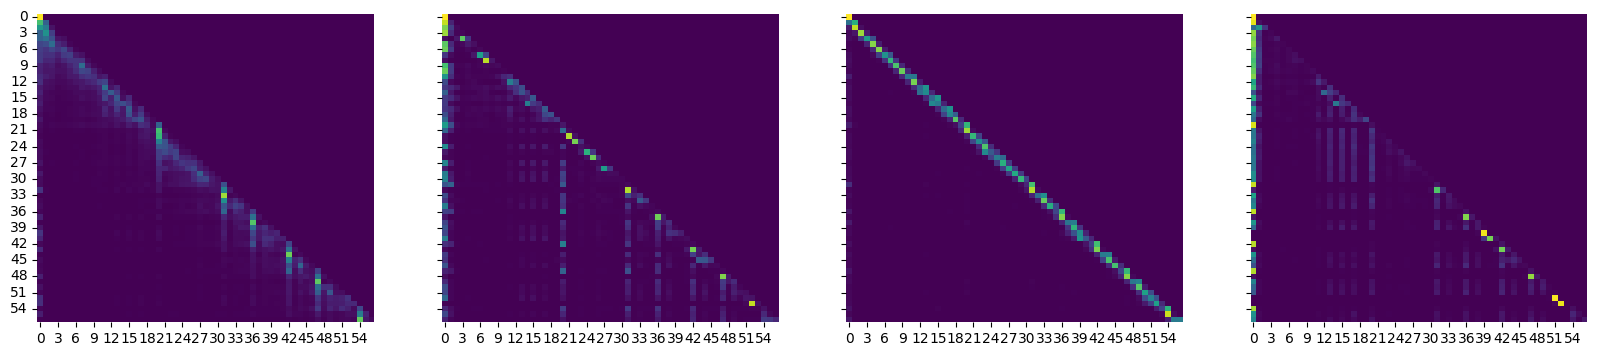

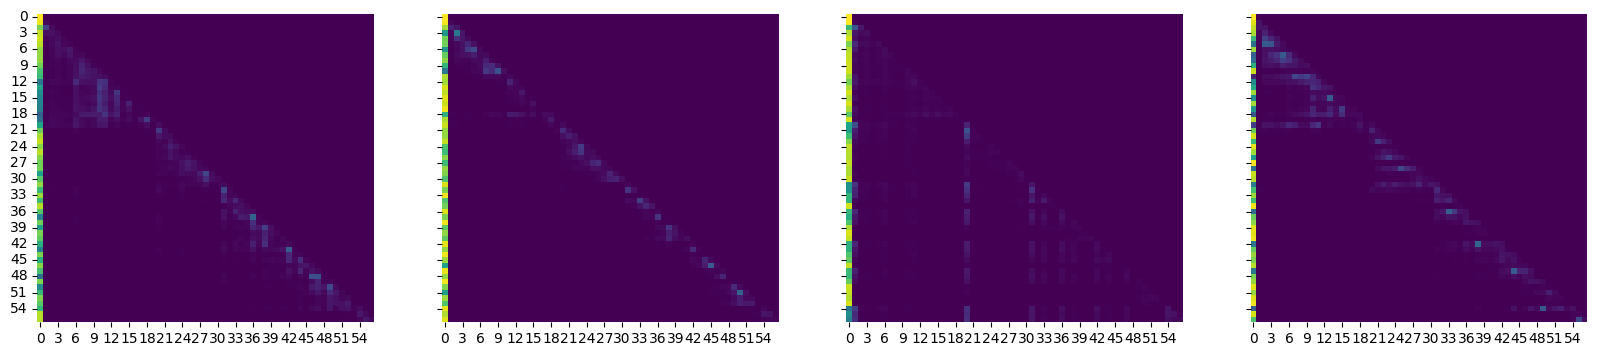

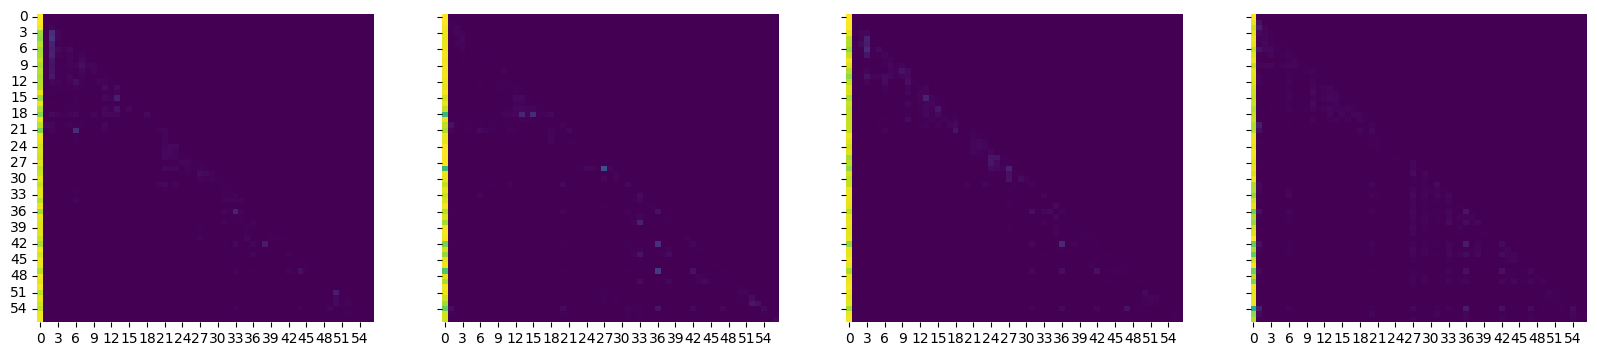

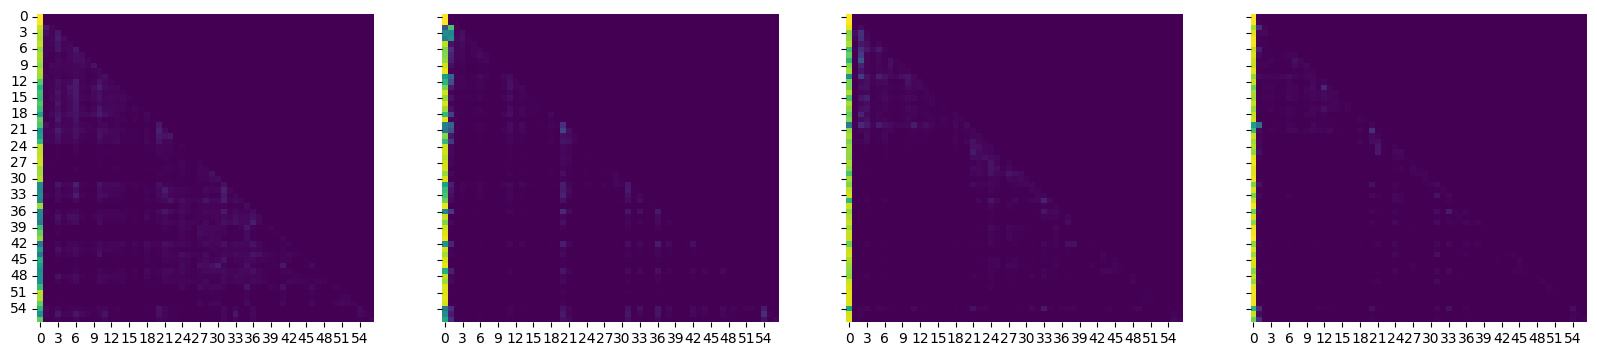

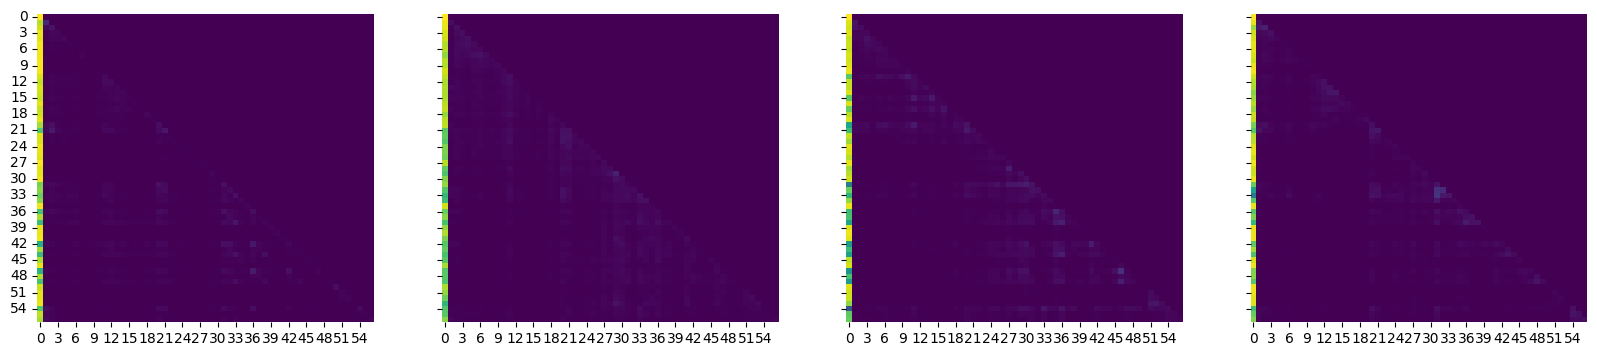

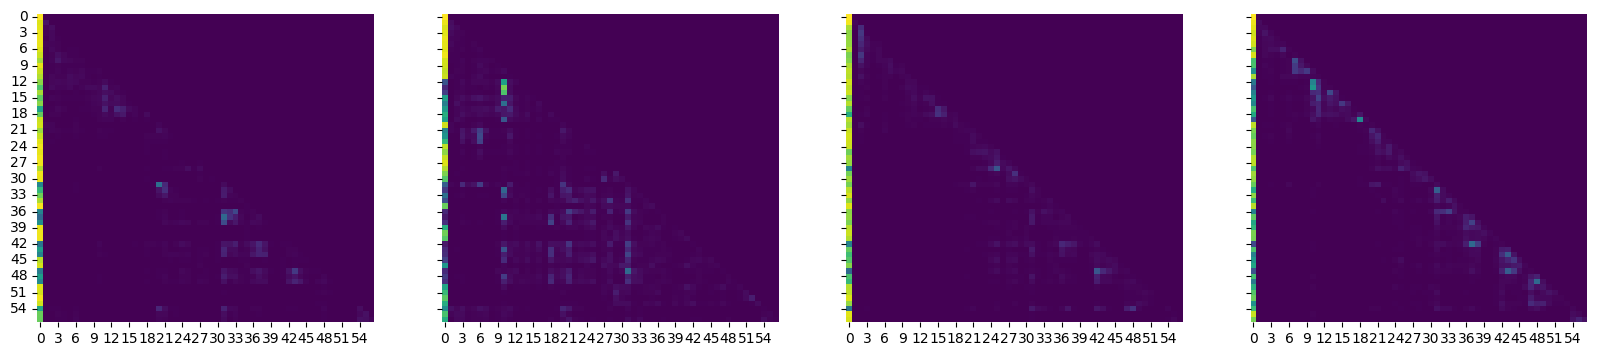

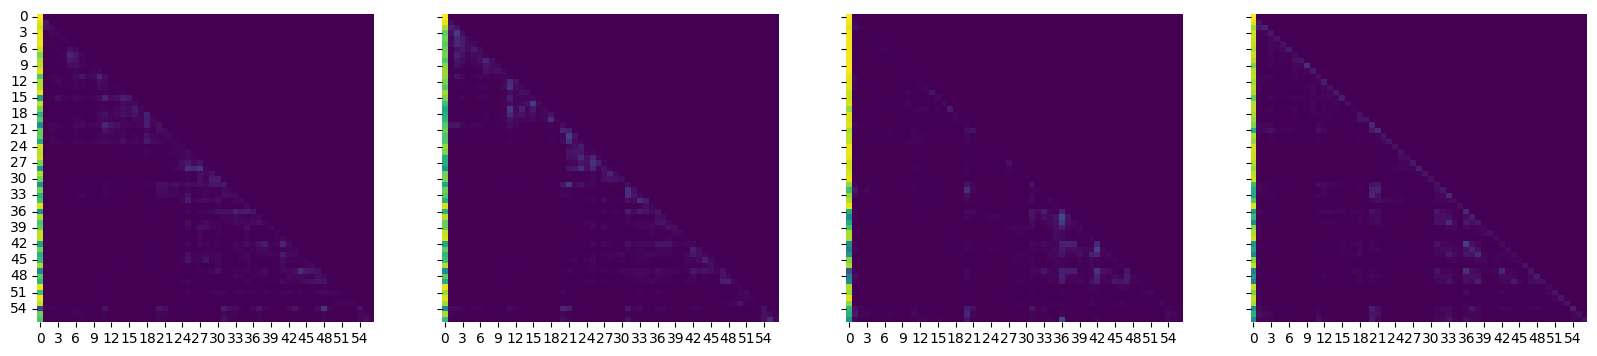

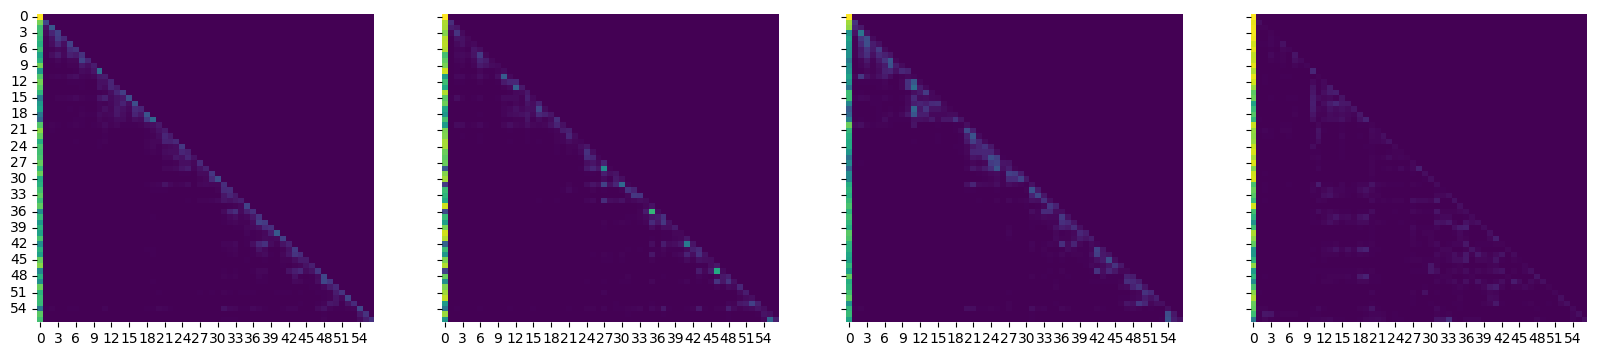

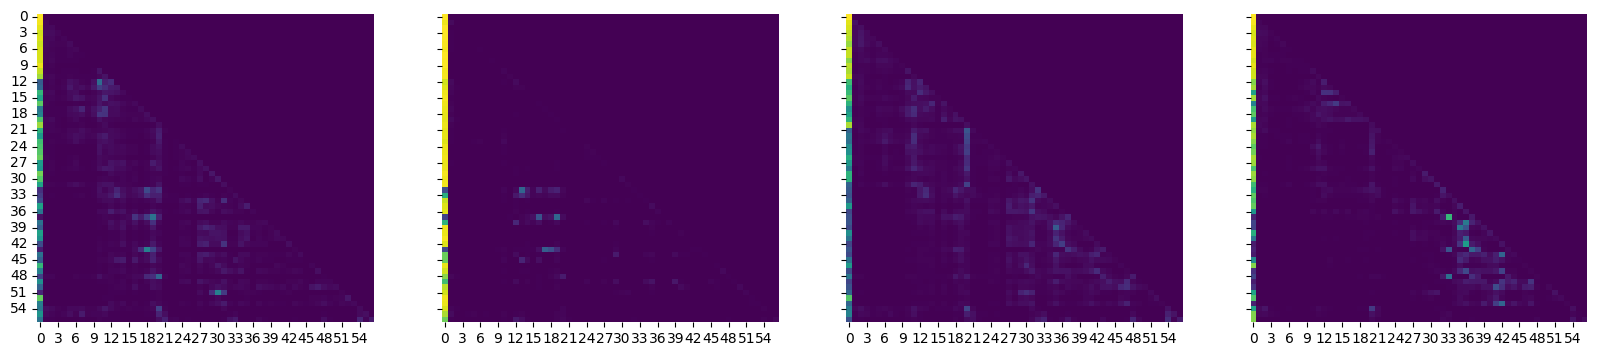

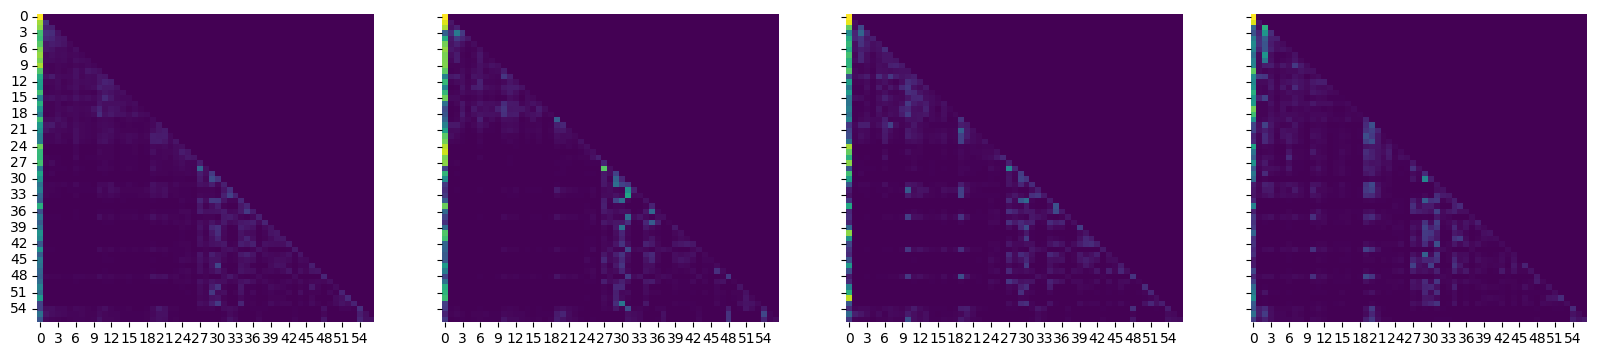

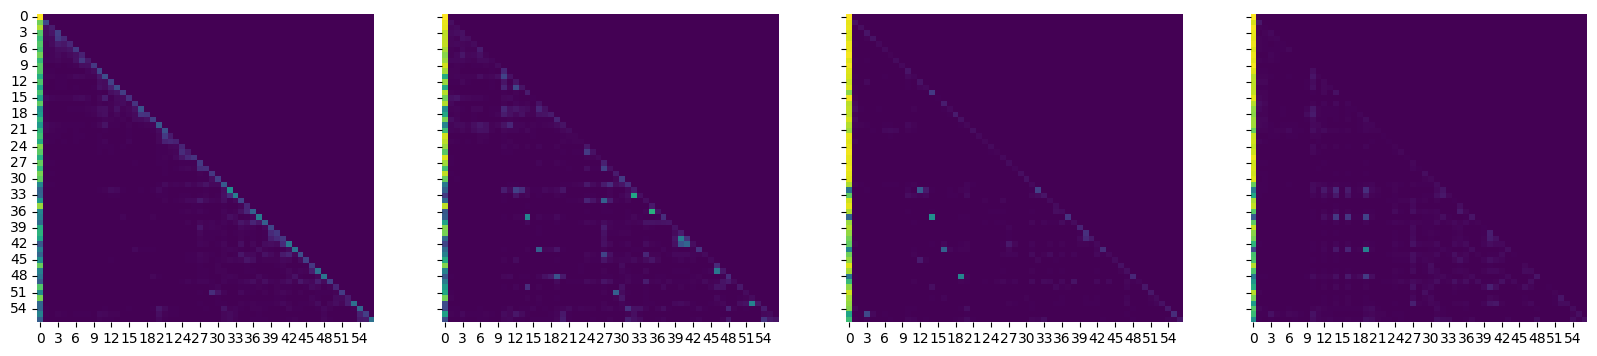

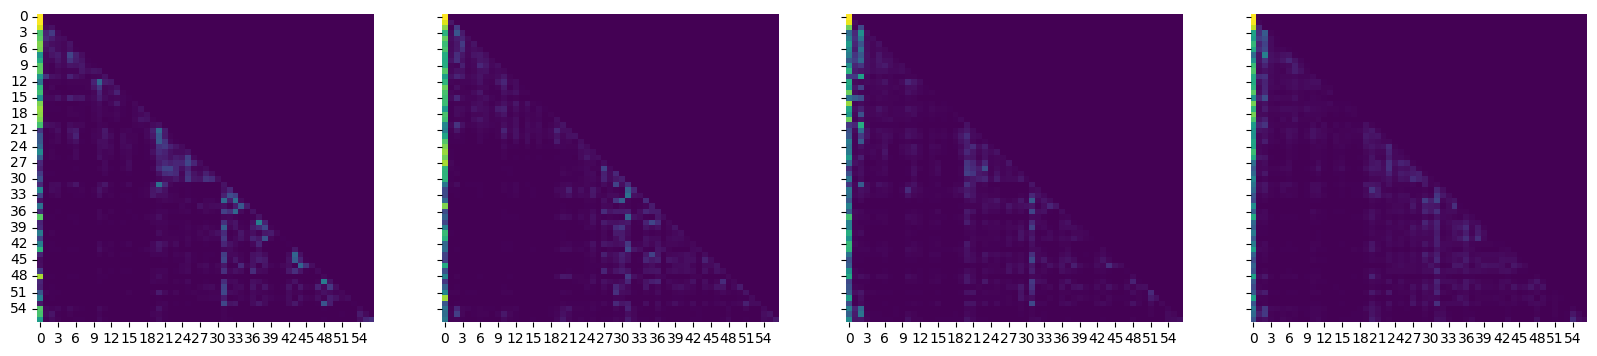

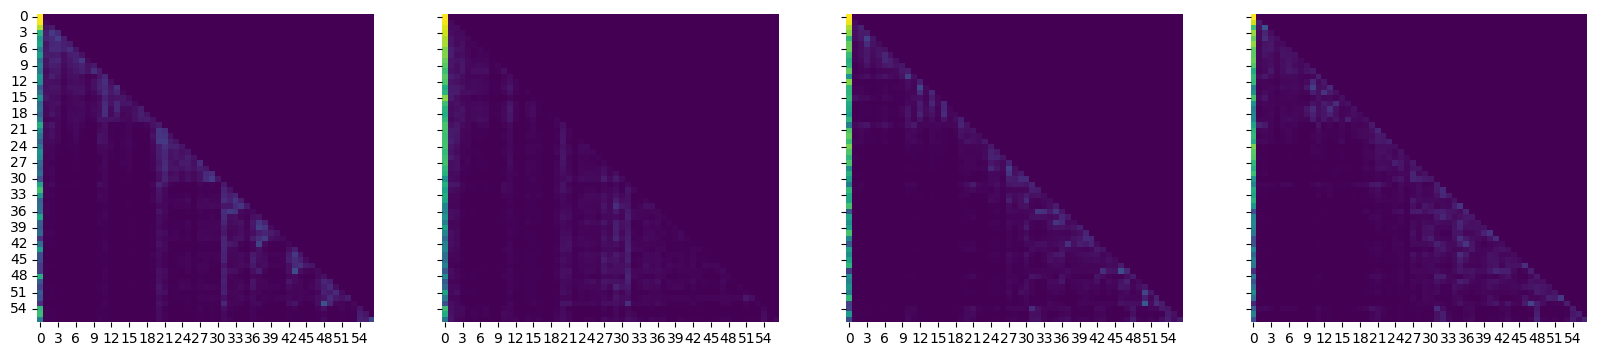

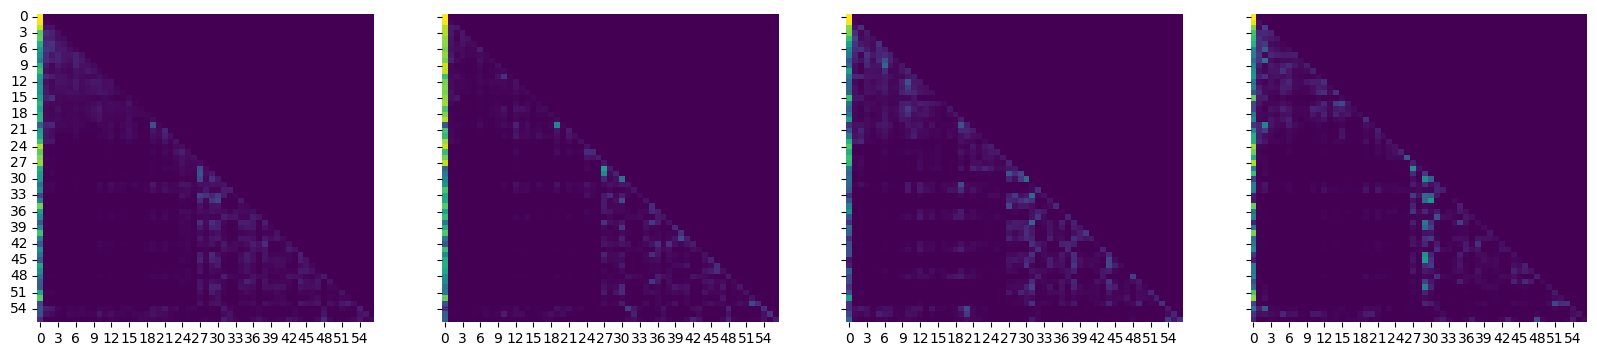

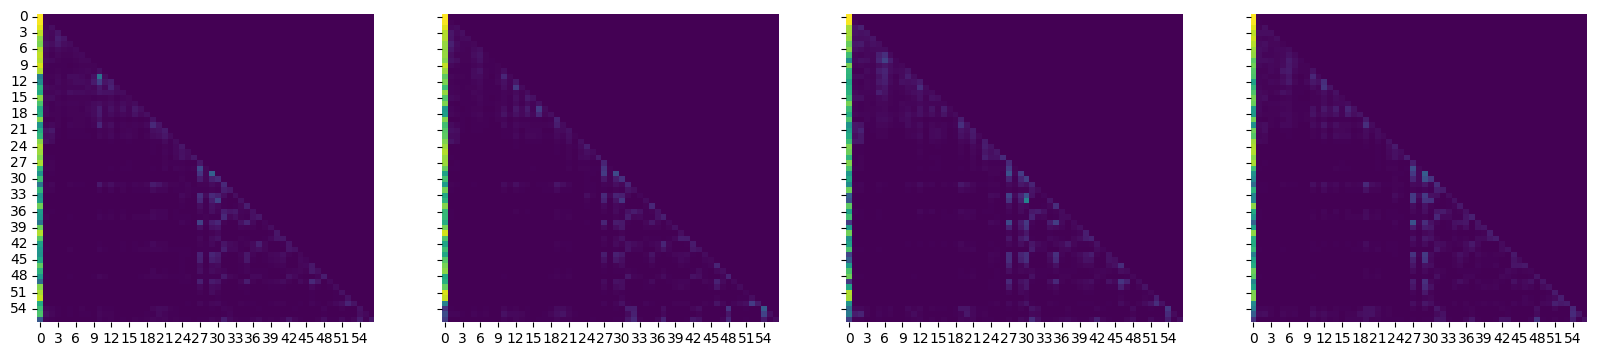

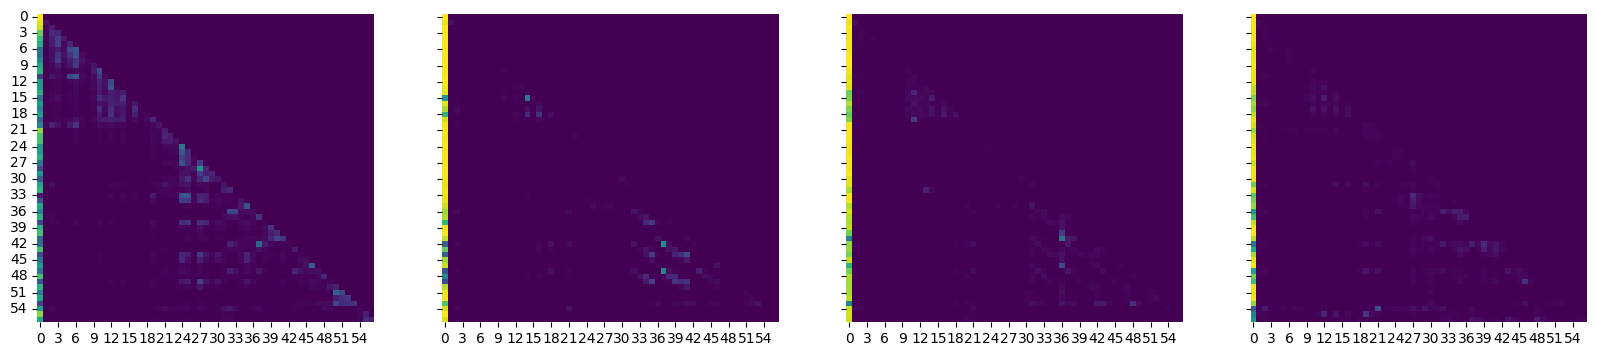

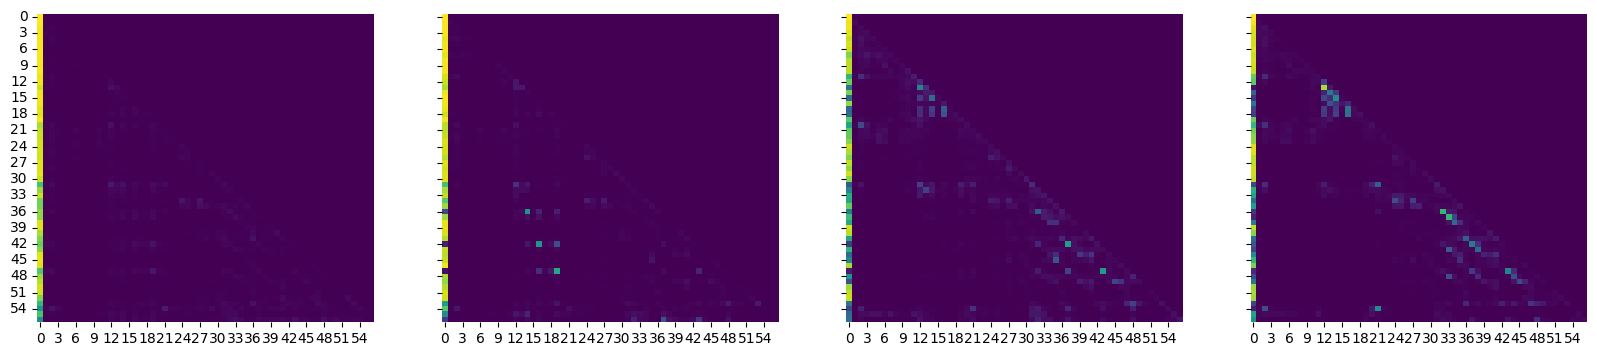

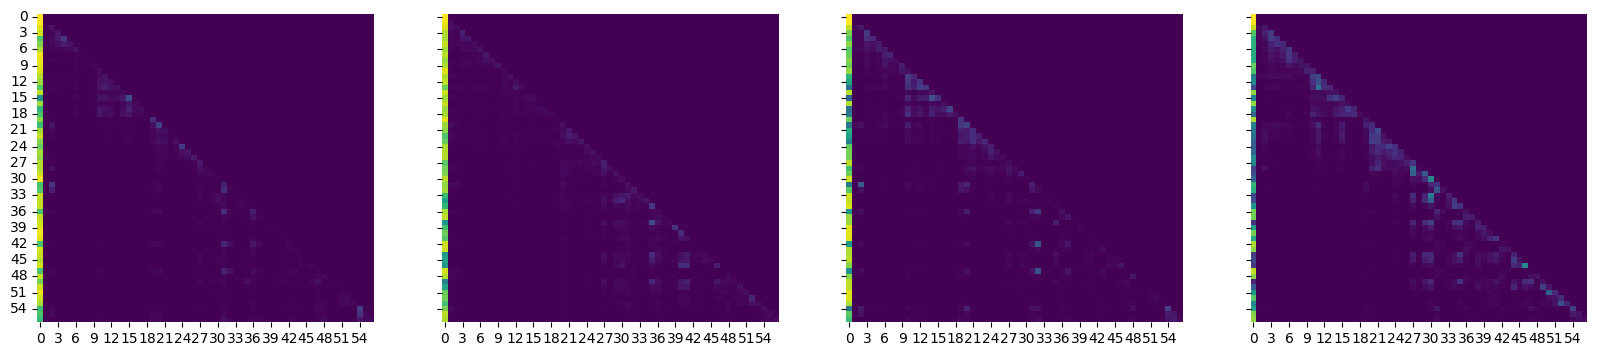

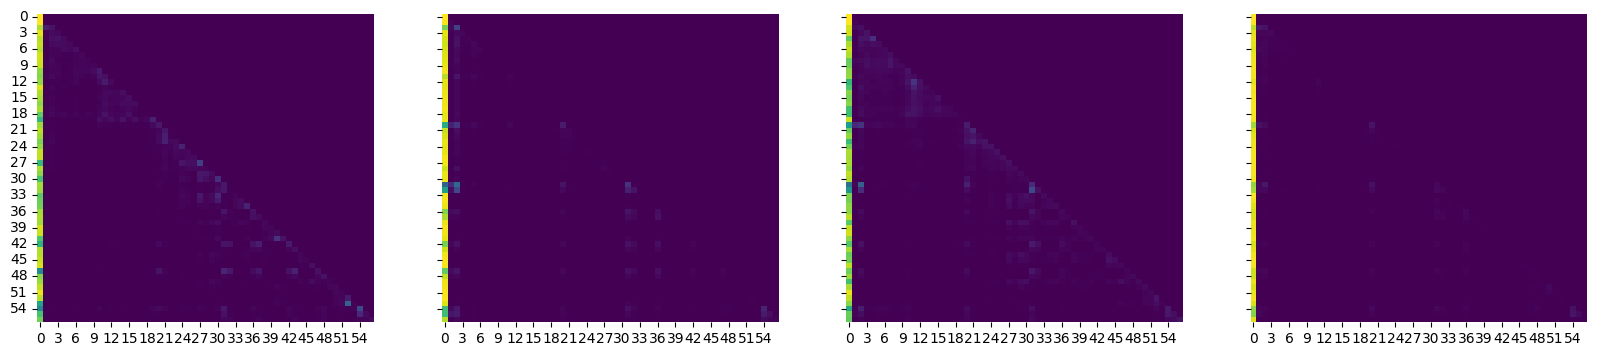

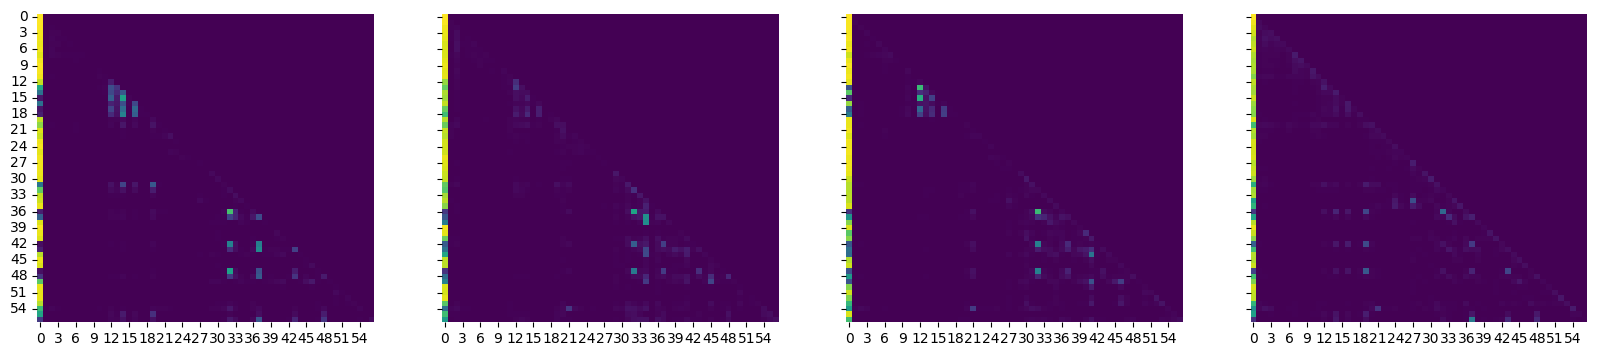

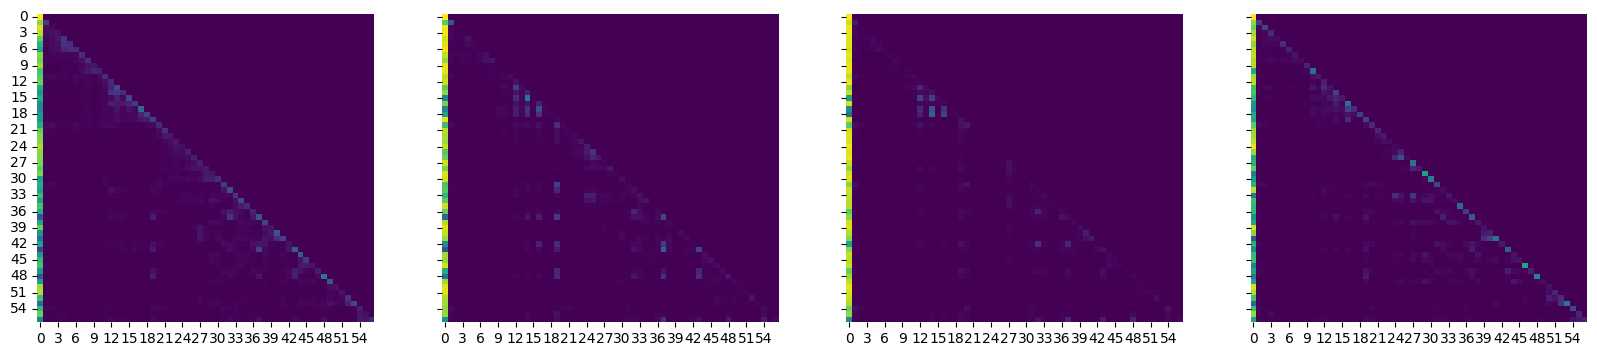

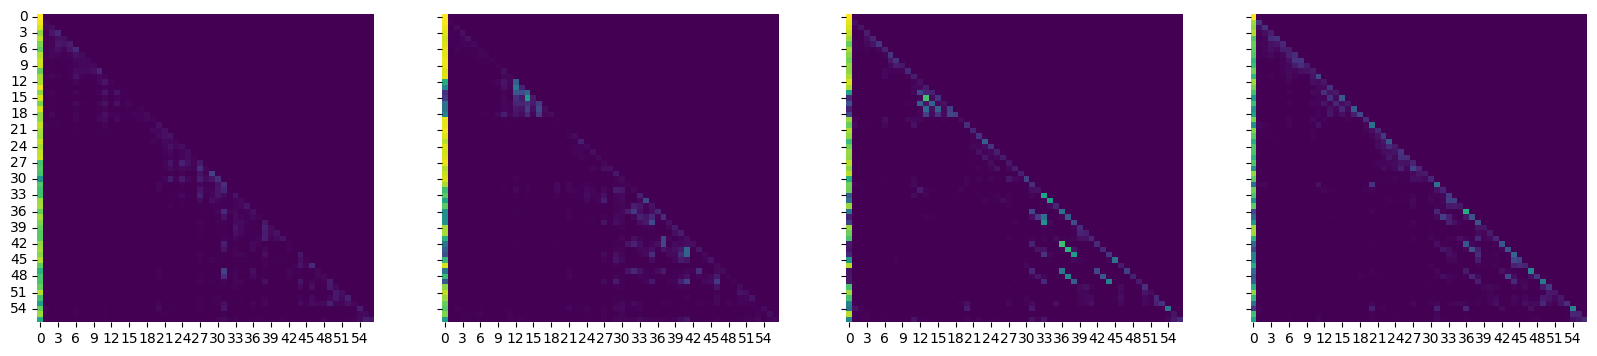

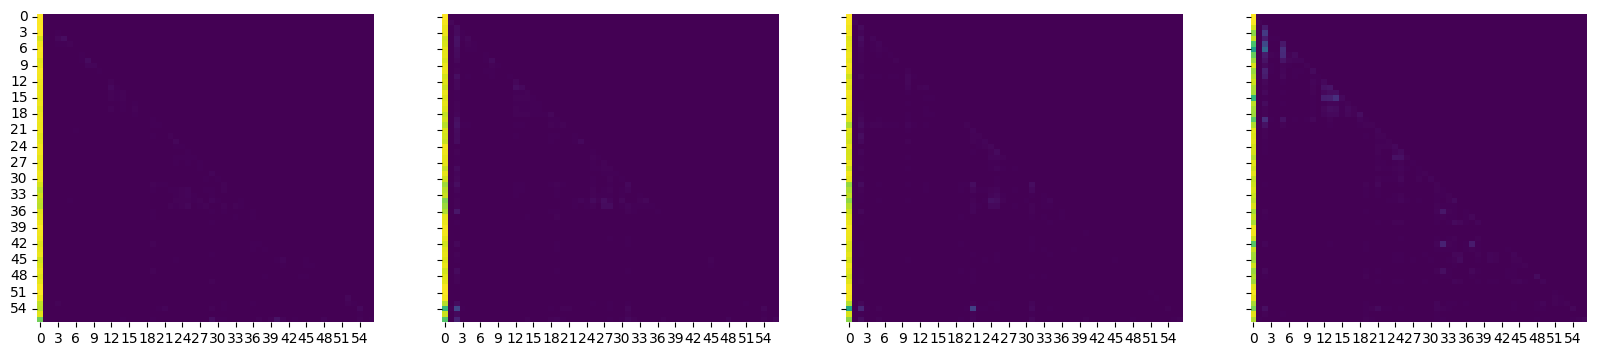

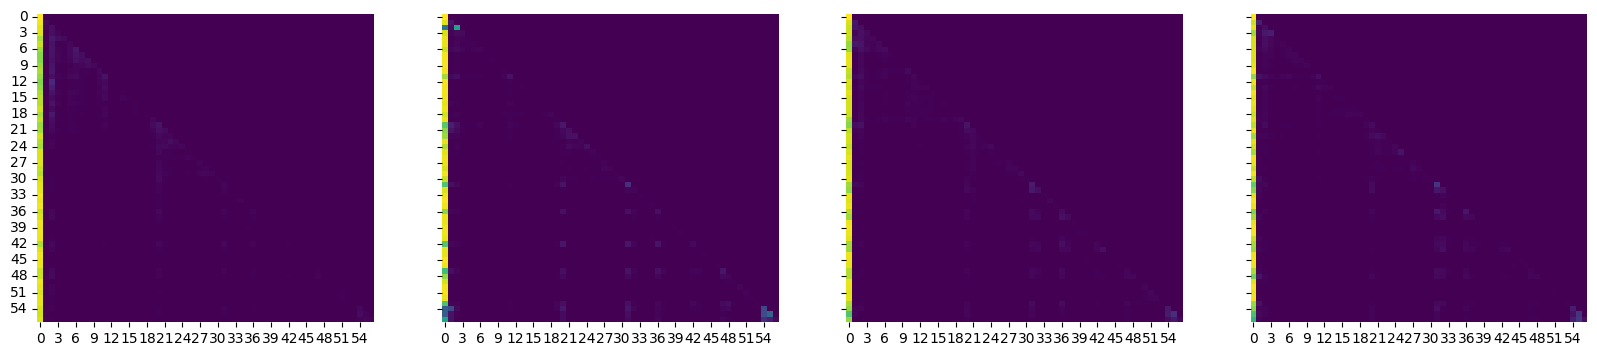

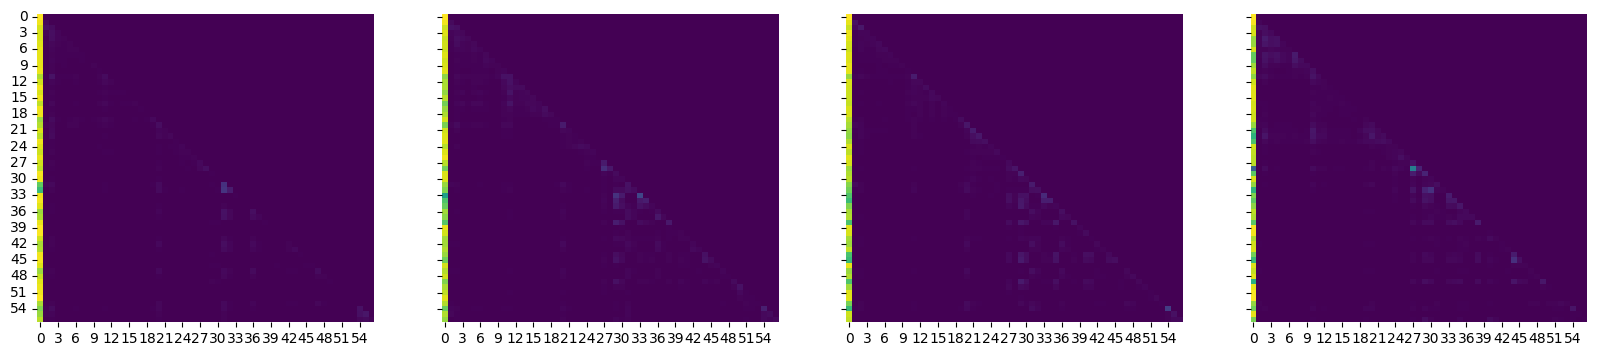

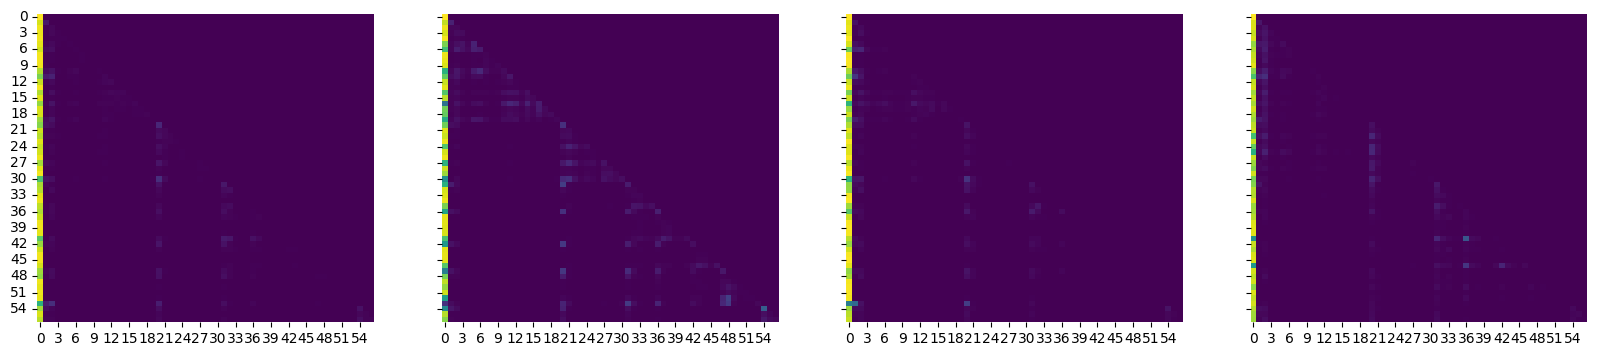

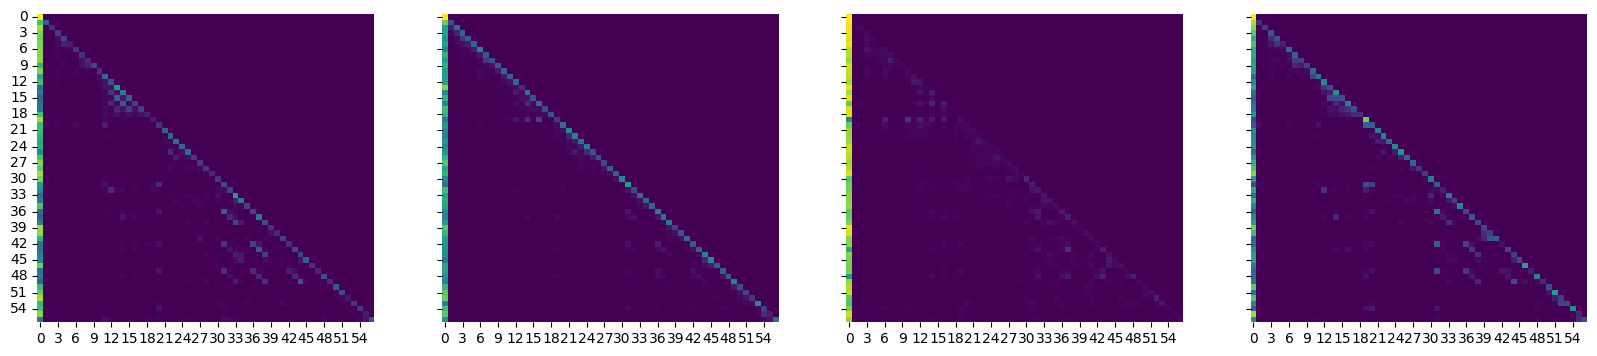

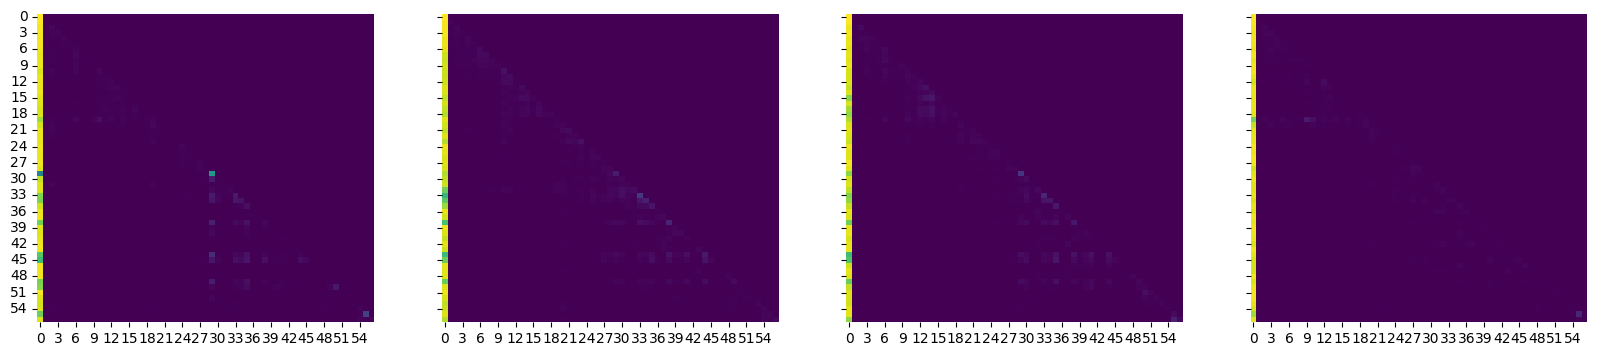

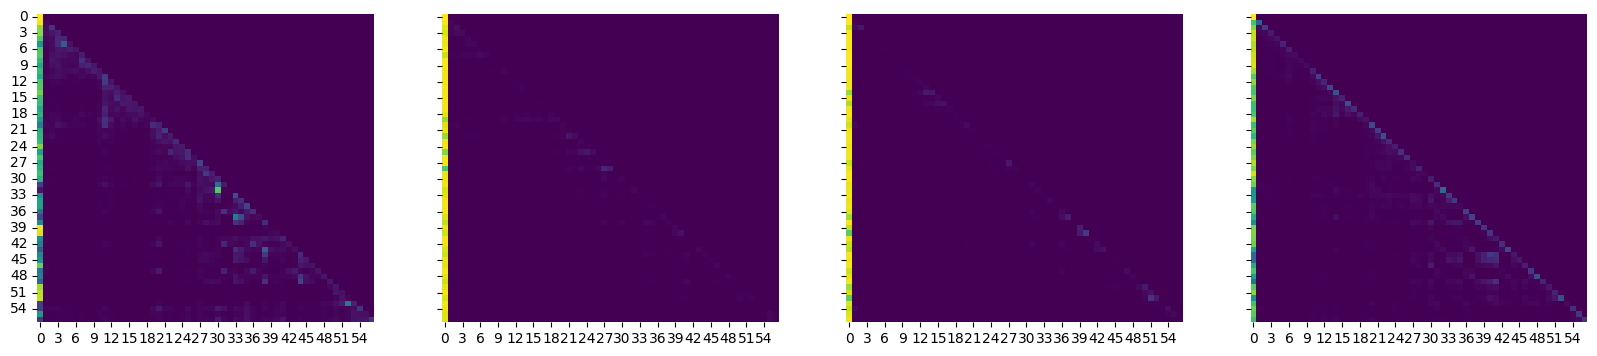

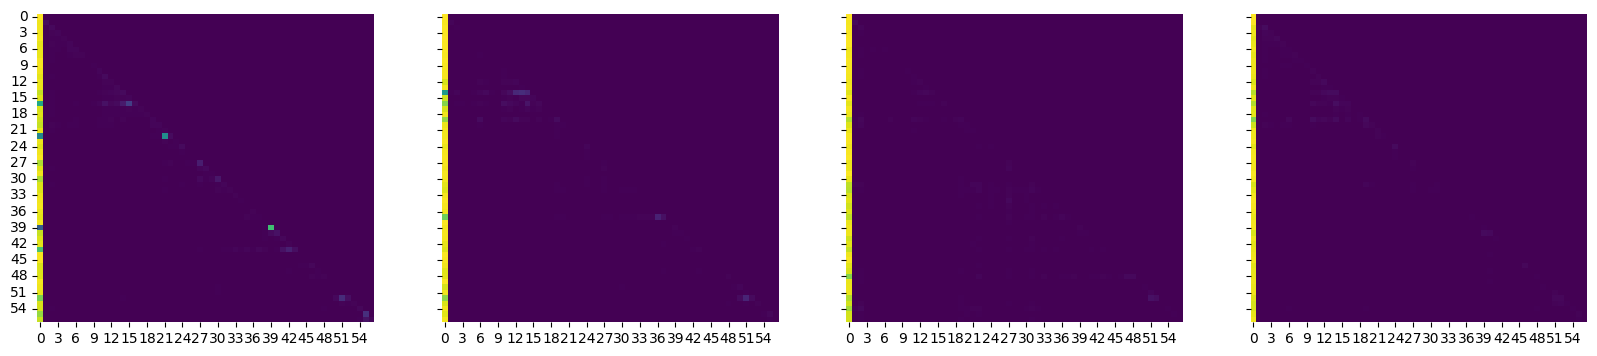

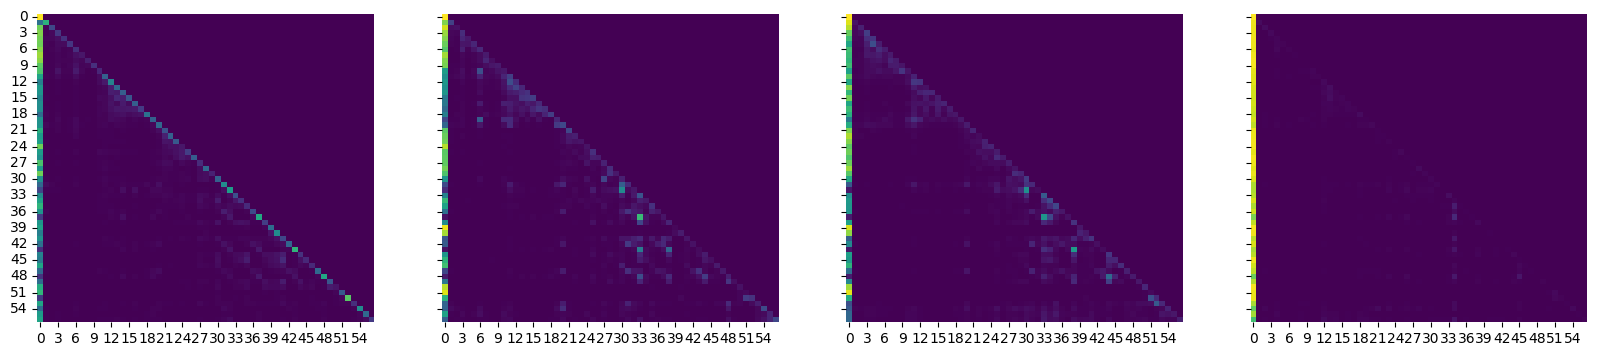

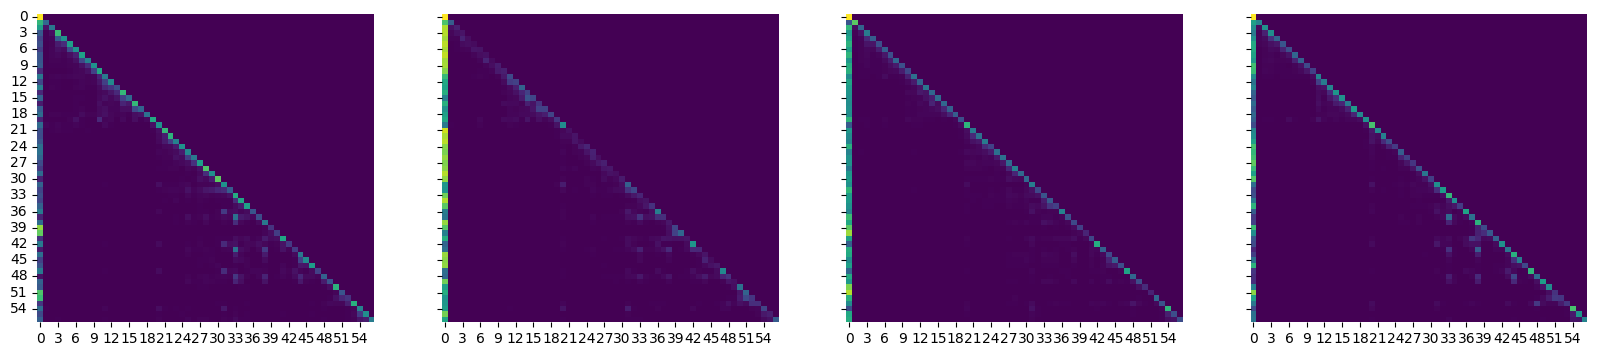

In [23]:
for layer in range(len(attention_maps[0])):
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(20, 4))
    sns.heatmap(attention_maps[0][layer][0][0].cpu().to(torch.float32).detach().numpy(), cmap='viridis', cbar=False, ax=axes[0])
    sns.heatmap(attention_maps[0][layer][0][1].cpu().to(torch.float32).detach().numpy(), cmap='viridis', cbar=False, ax=axes[1])
    sns.heatmap(attention_maps[0][layer][0][2].cpu().to(torch.float32).detach().numpy(), cmap='viridis', cbar=False, ax=axes[2])
    sns.heatmap(attention_maps[0][layer][0][3].cpu().to(torch.float32).detach().numpy(), cmap='viridis', cbar=False, ax=axes[3])
    plt.show()

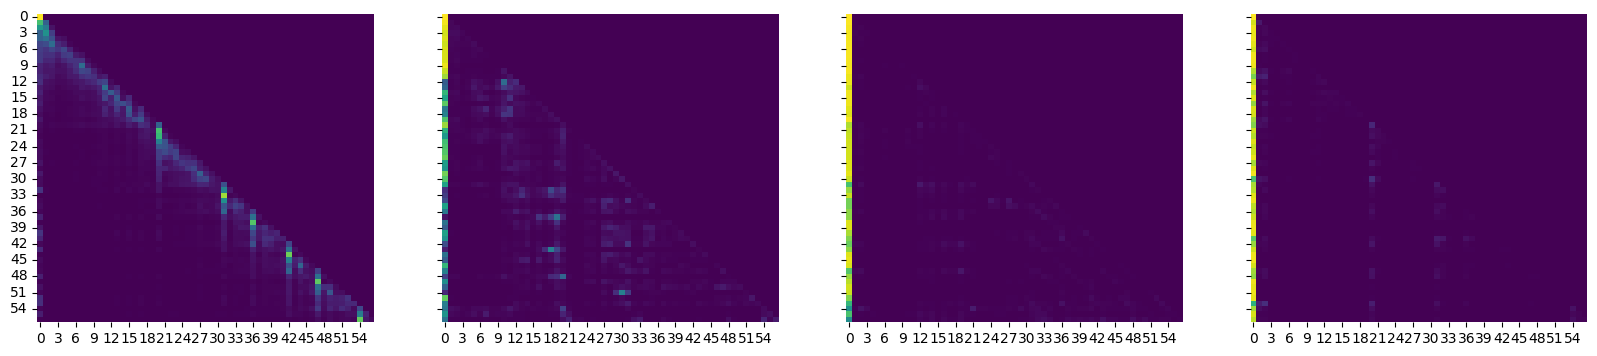

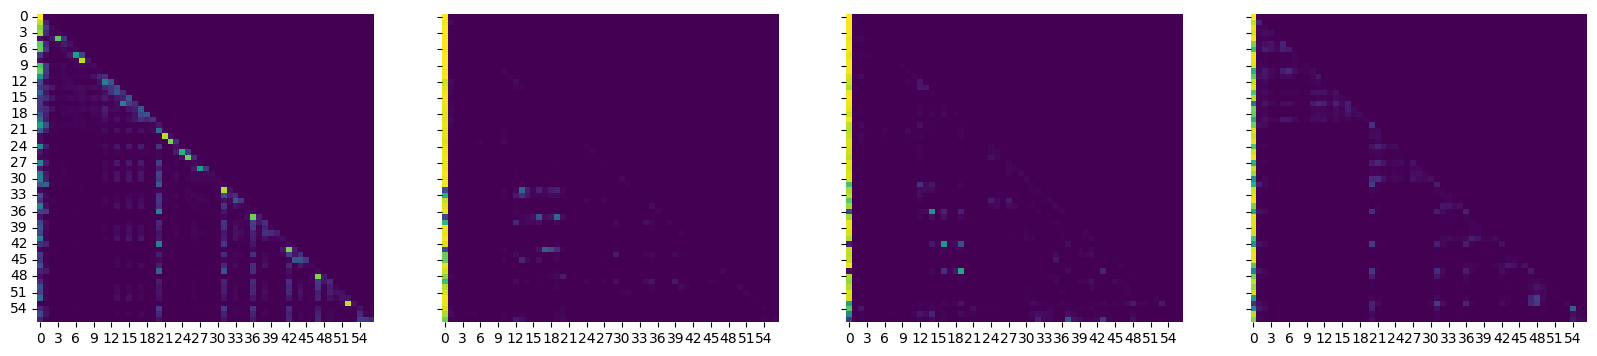

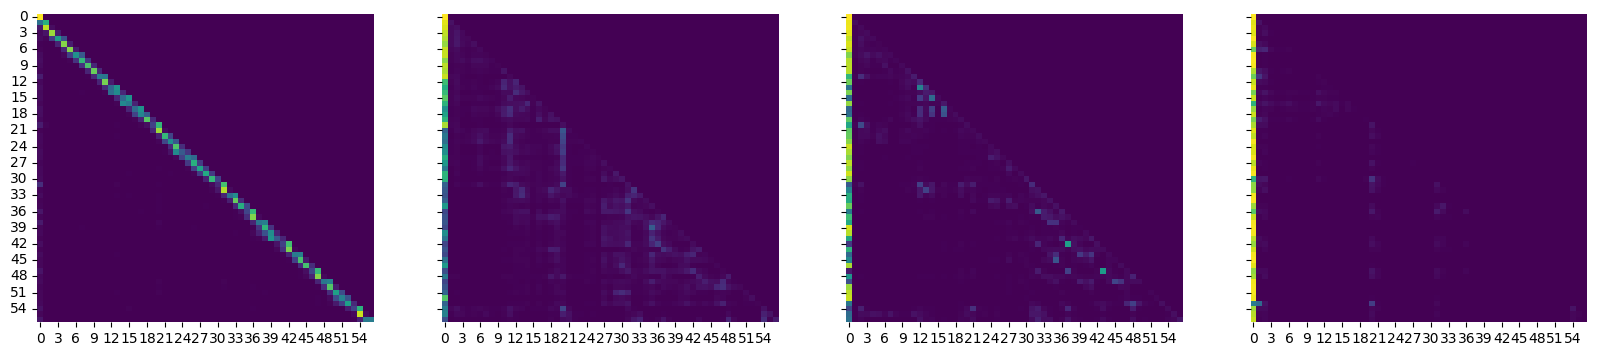

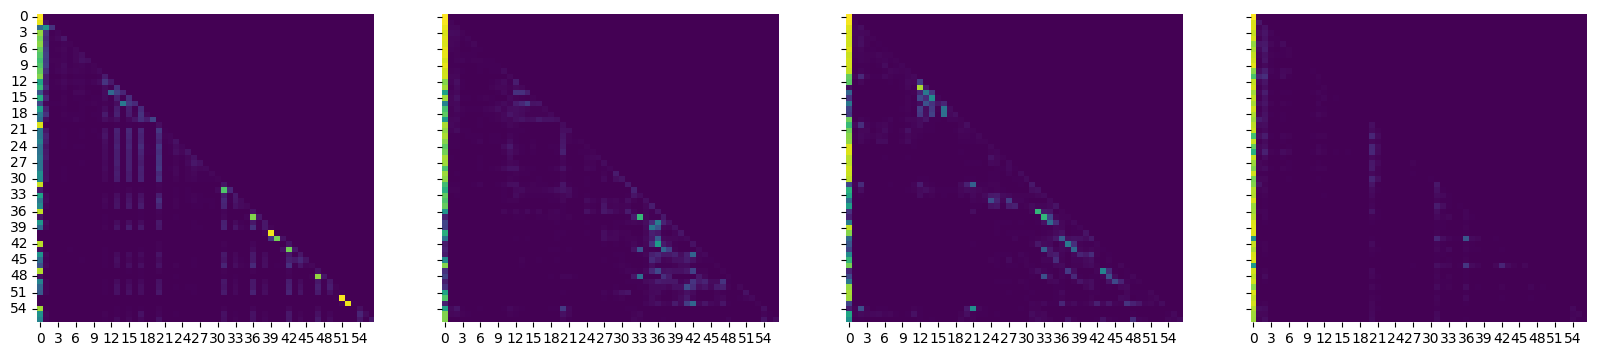

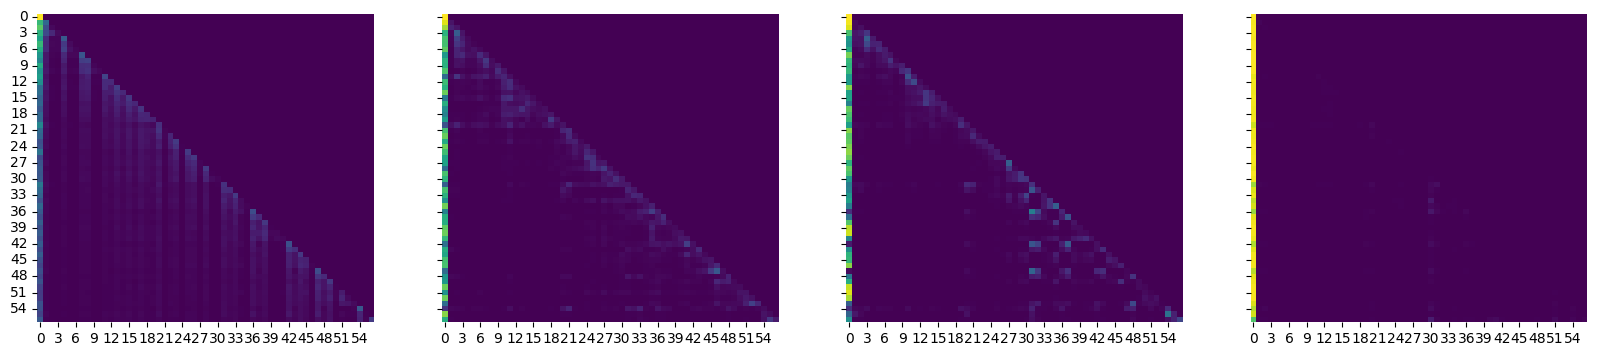

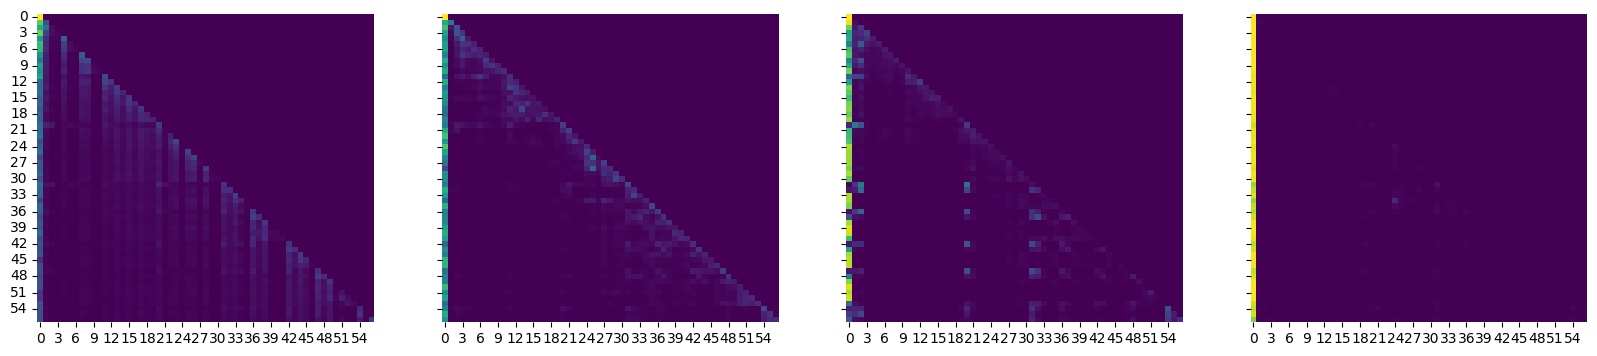

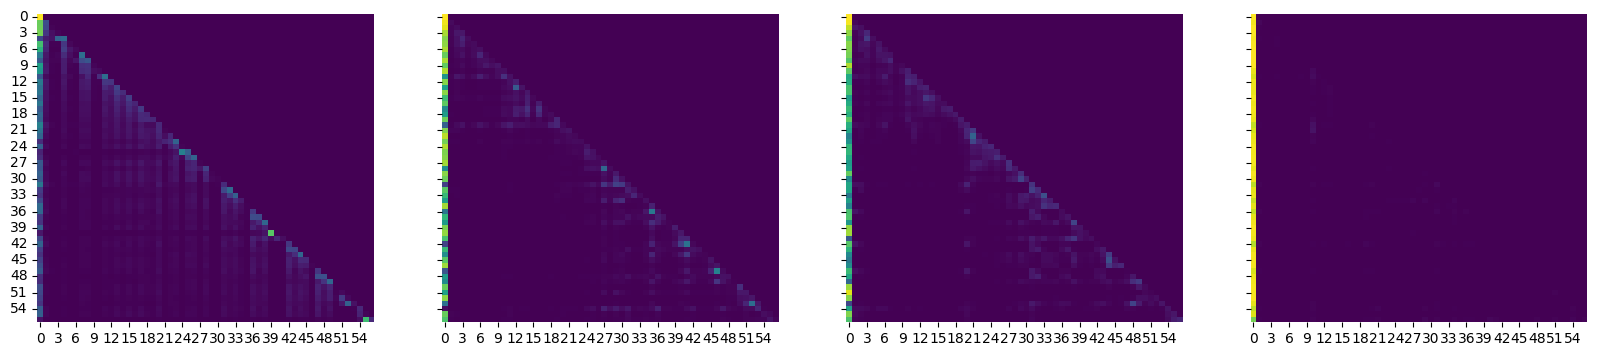

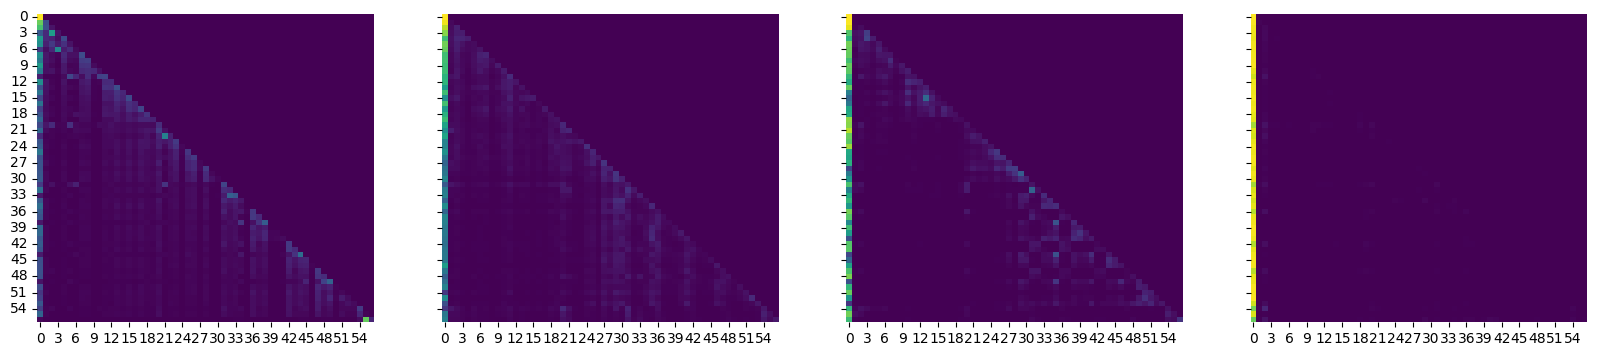

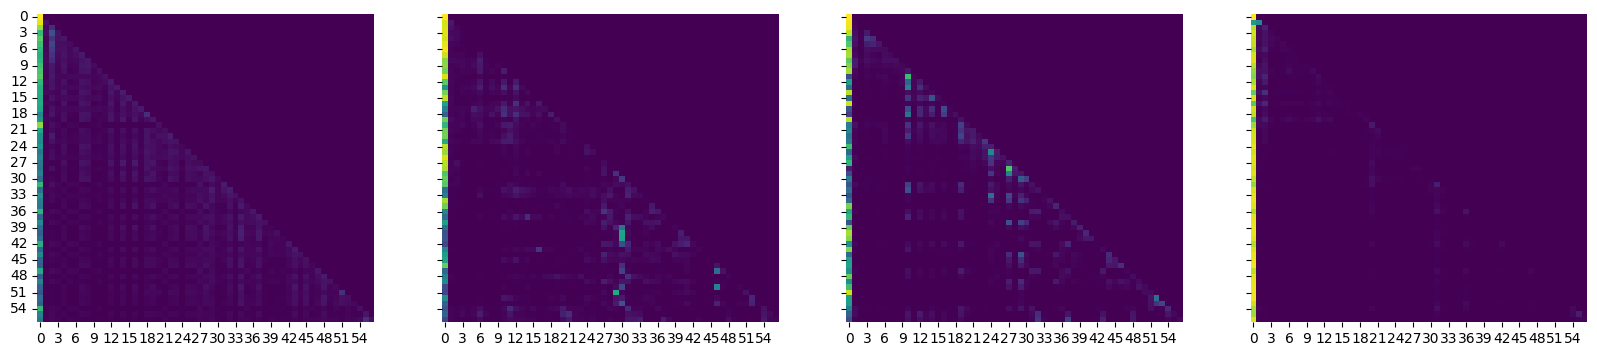

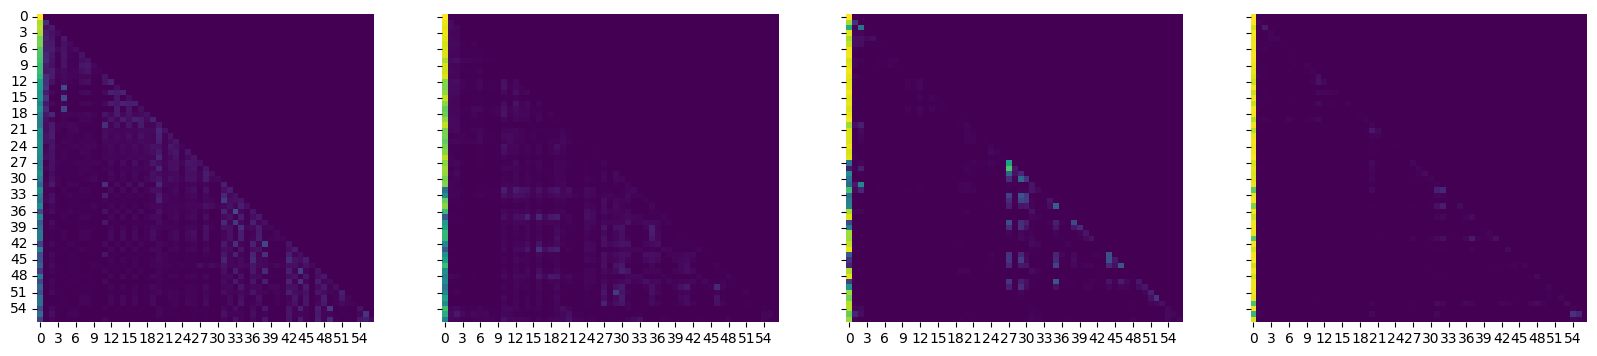

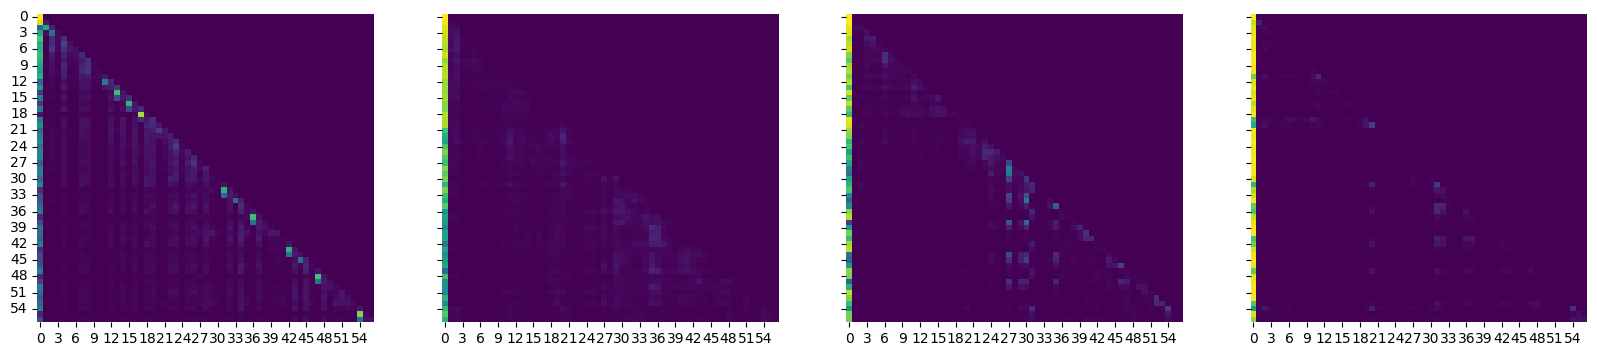

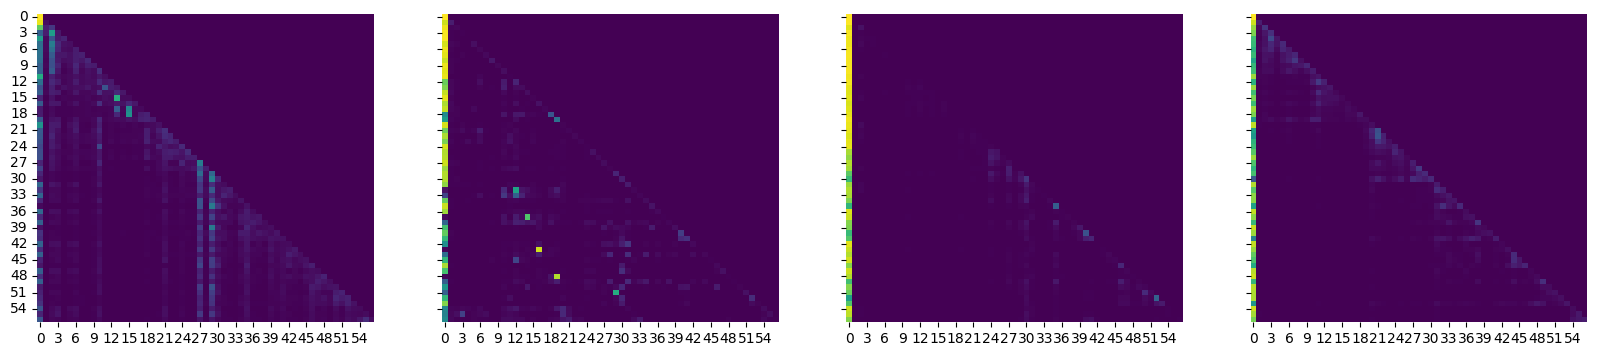

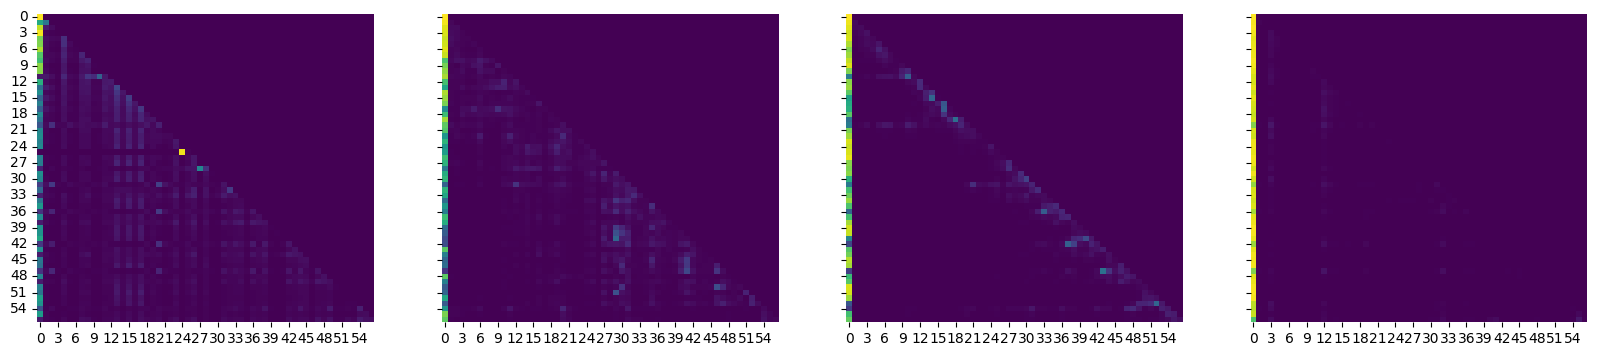

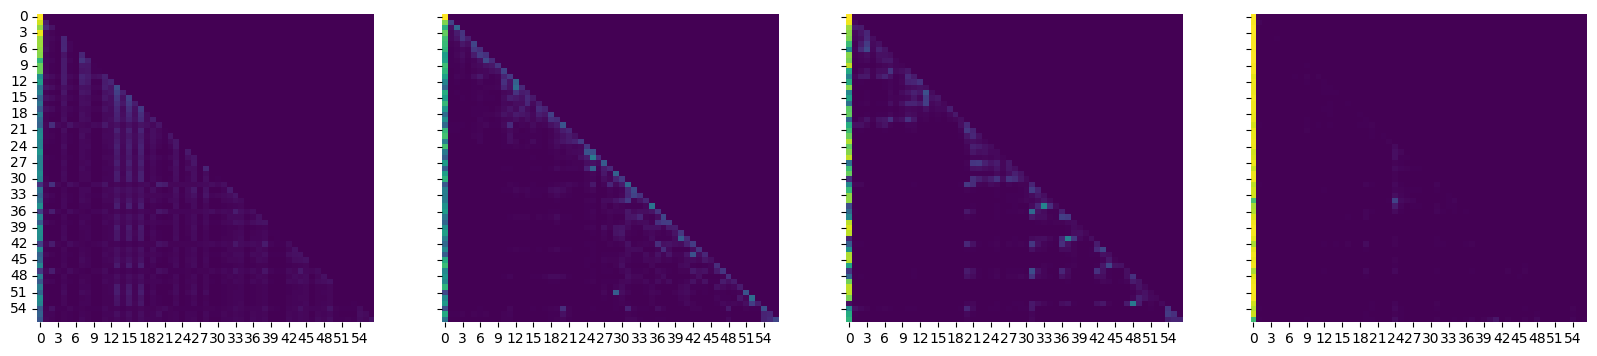

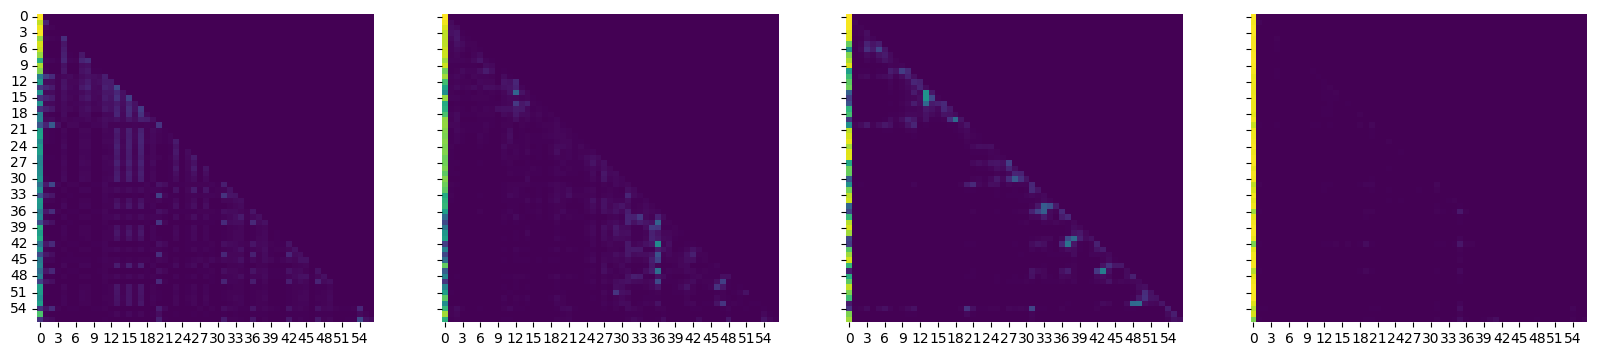

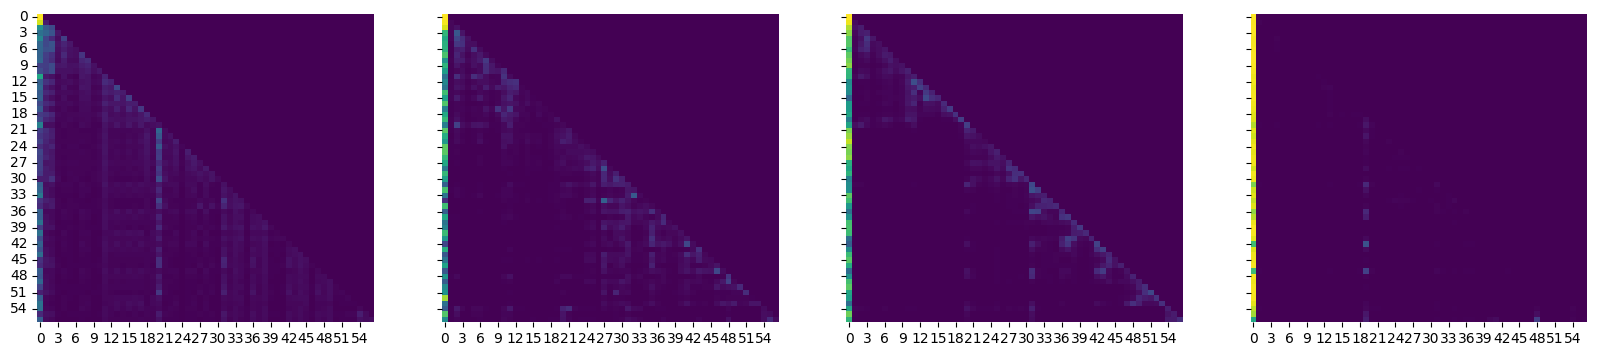

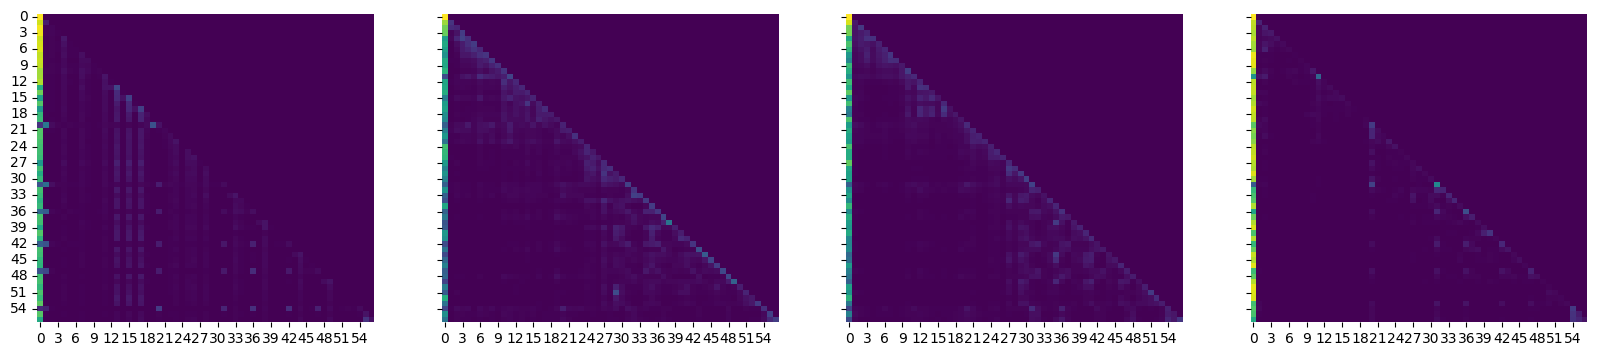

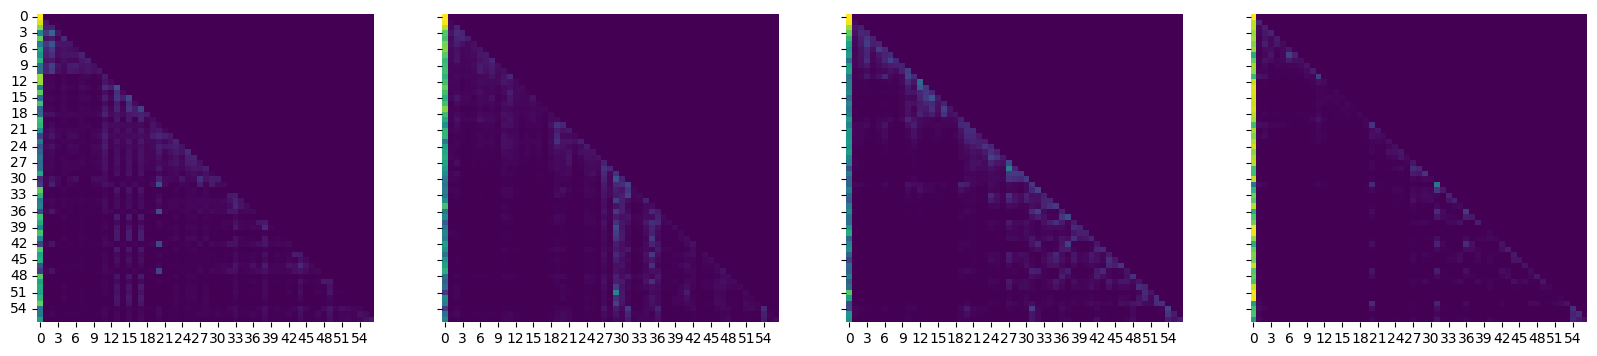

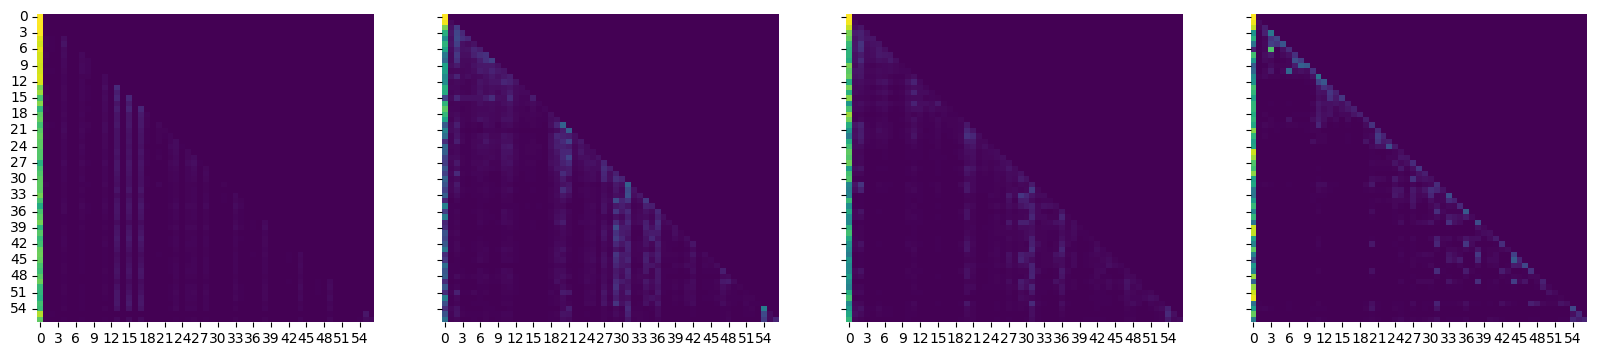

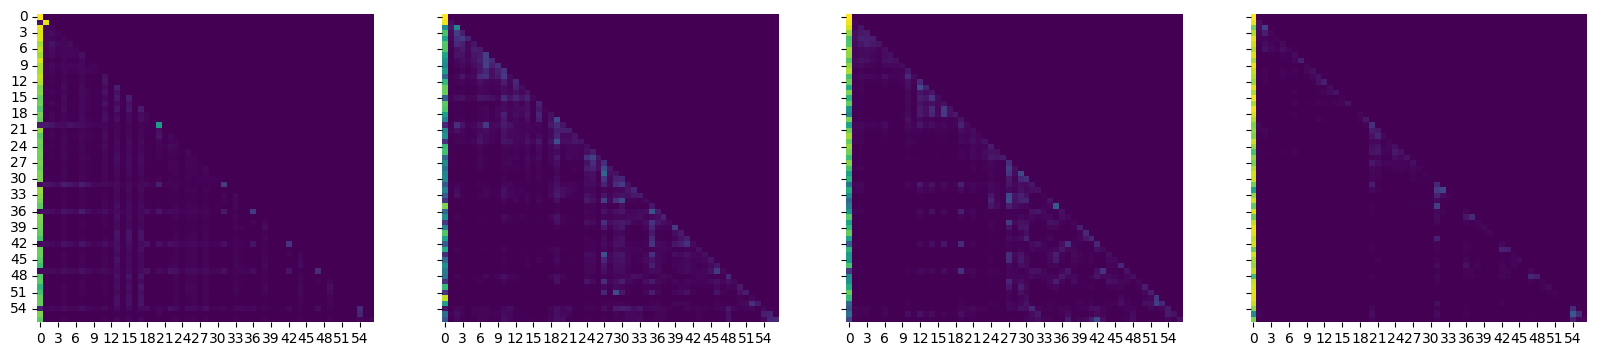

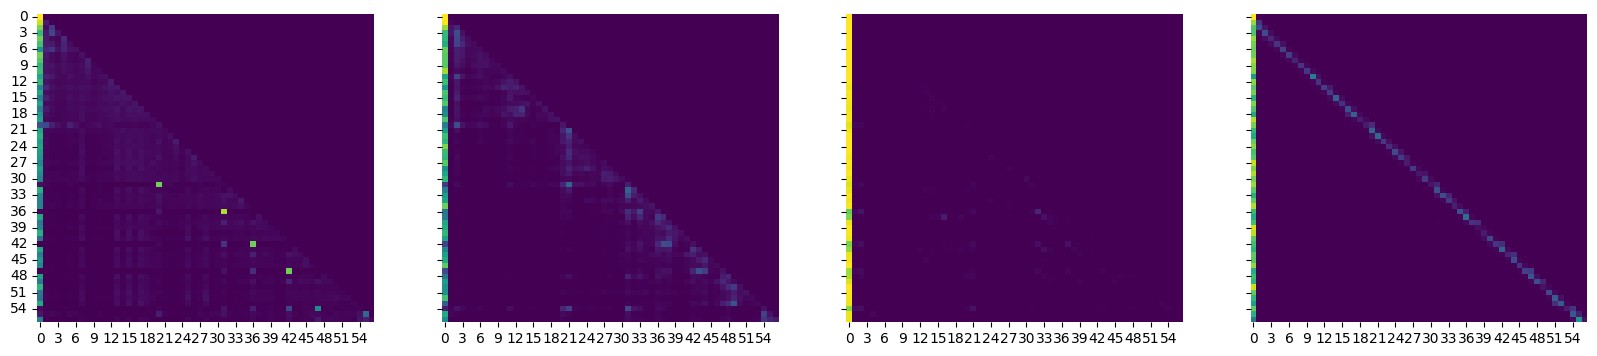

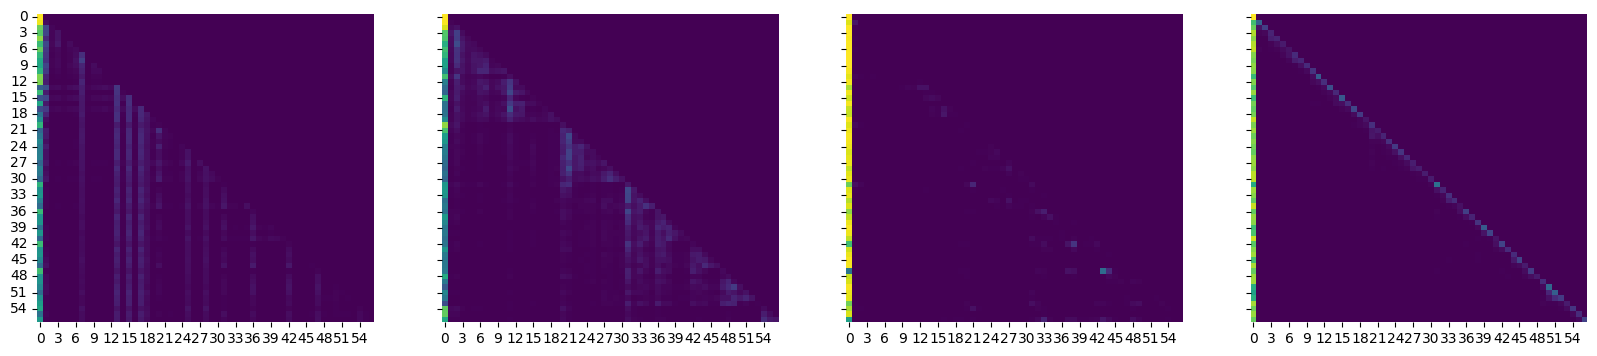

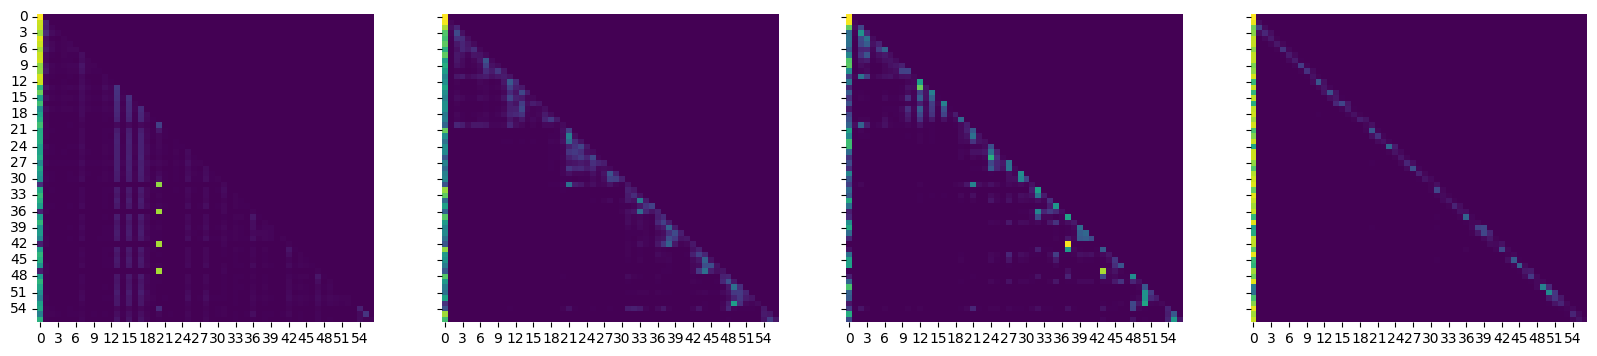

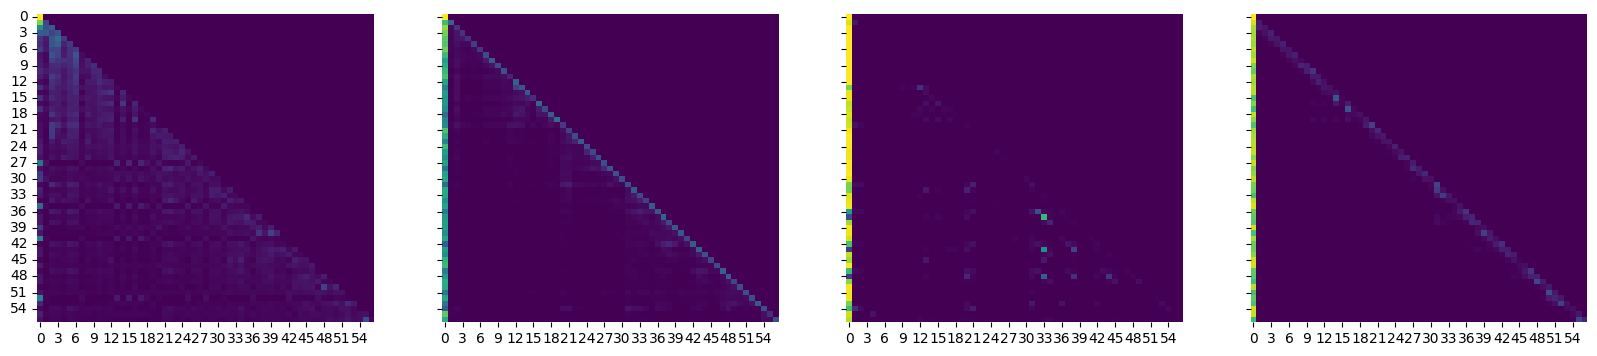

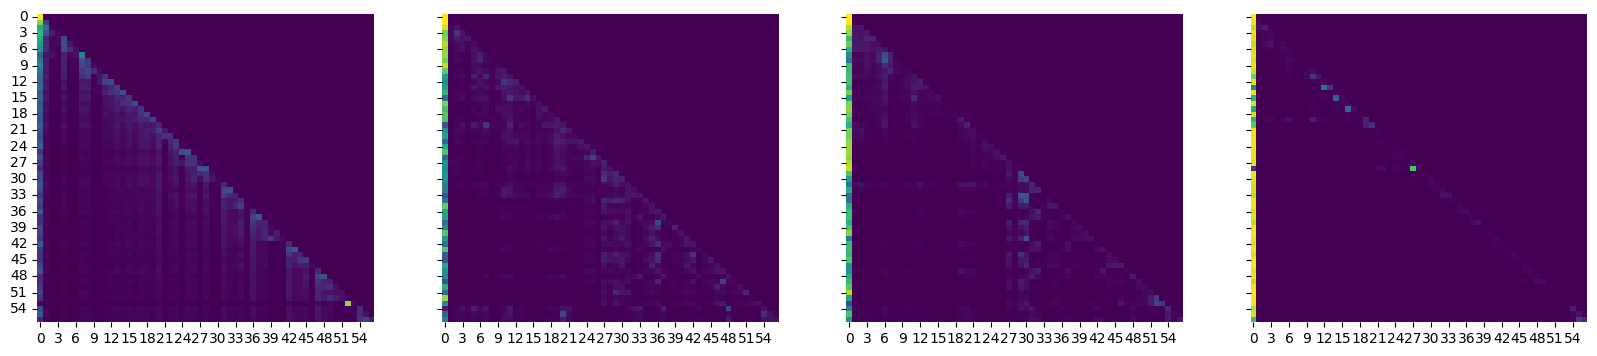

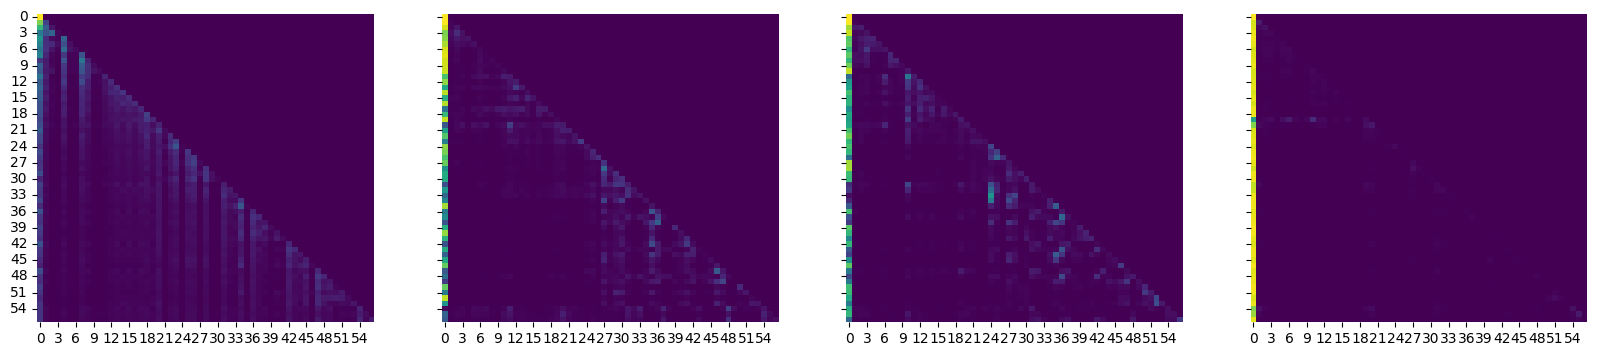

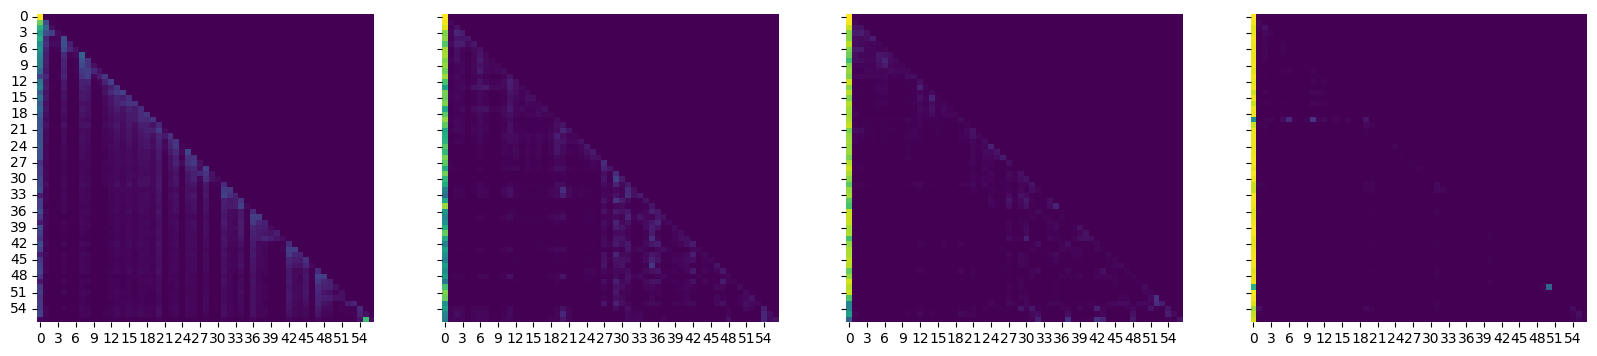

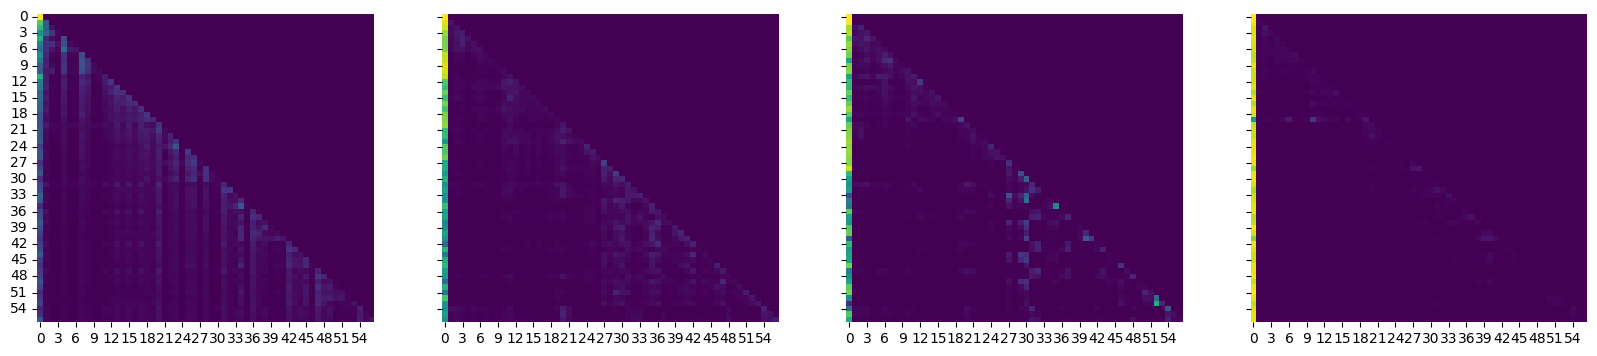

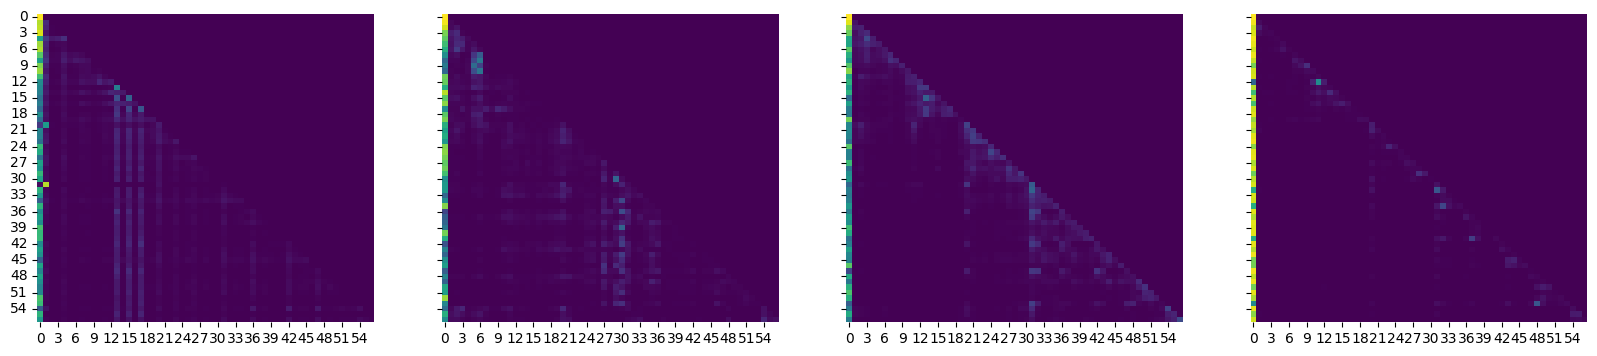

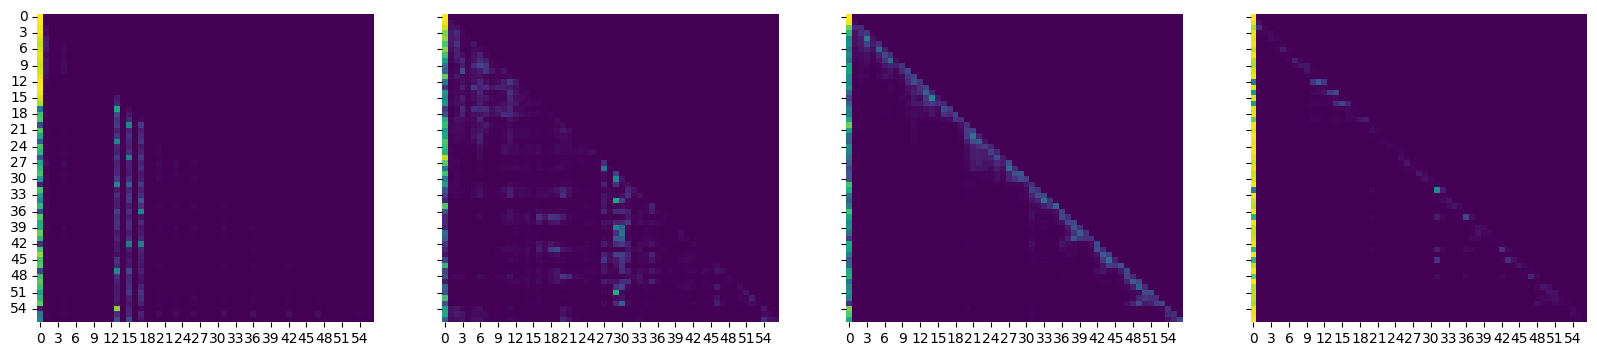

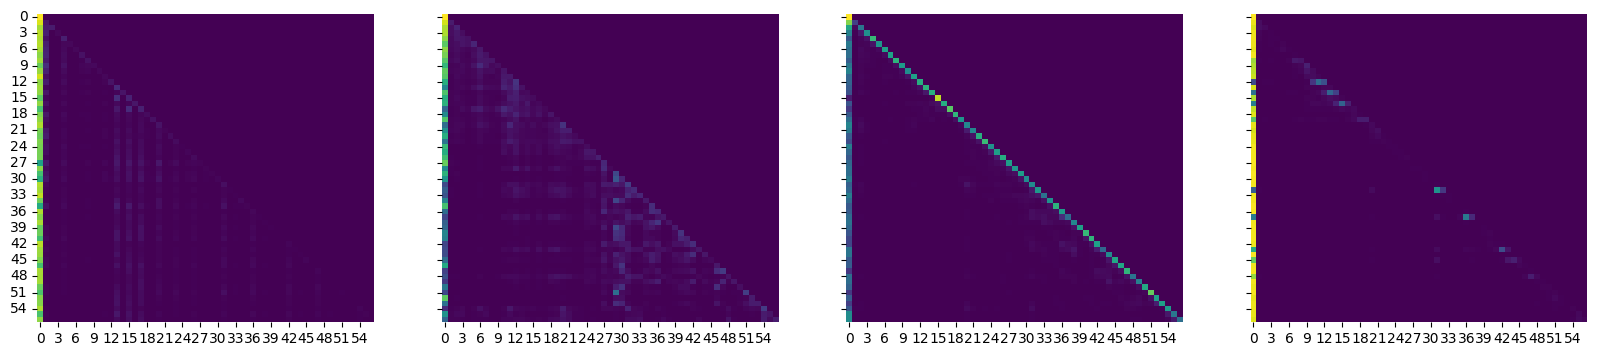

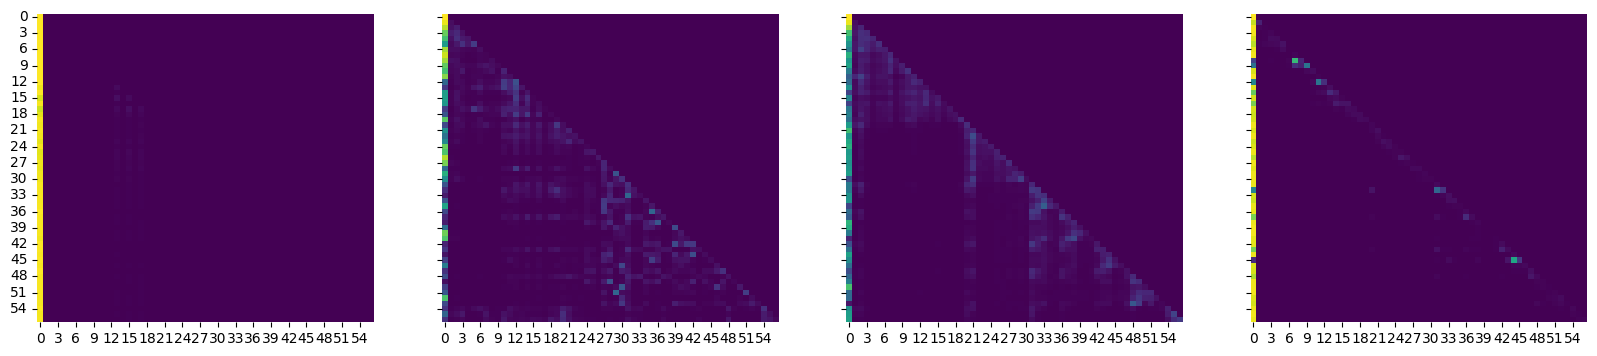

In [24]:
for head in range(32):
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(20, 4))
    sns.heatmap(attention_maps[0][0][0][head].cpu().to(torch.float32).detach().numpy(), cmap='viridis', cbar=False, ax=axes[0])
    sns.heatmap(attention_maps[0][8][0][head].cpu().to(torch.float32).detach().numpy(), cmap='viridis', cbar=False, ax=axes[1])
    sns.heatmap(attention_maps[0][16][0][head].cpu().to(torch.float32).detach().numpy(), cmap='viridis', cbar=False, ax=axes[2])
    sns.heatmap(attention_maps[0][25][0][head].cpu().to(torch.float32).detach().numpy(), cmap='viridis', cbar=False, ax=axes[3])
    plt.show()